### Figures for Wei et al

In [1]:
import os
import sys
print("Python version" + sys.version)
os.getcwd()
print(sys.executable)

Python version3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) 
[GCC 9.4.0]
/home/obermayb_c/miniconda3/envs/ccism/bin/python3.9


In [2]:
import numpy as np
np.random.seed(123)
import pandas as pd
import scipy
import itertools

import umap
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import scanpy as sc
import anndata as ad
import scvelo as scv
from tqdm.notebook import tqdm

from pathlib import Path

TF_ENABLE_ONEDNN_OPTS=0

2024-05-16 10:33:41.846760: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 10:33:41.849054: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-16 10:33:41.849062: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import venn

In [4]:
import cellrank as cr

In [5]:
cr.__version__

'1.5.1'

In [6]:
from cellrank.kernels import CytoTRACEKernel

In [7]:
import scanpy.external as sce

In [8]:
from sklearn.metrics.cluster import adjusted_rand_score, homogeneity_completeness_v_measure, adjusted_mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score

In [9]:
sc.settings.verbosity = 1
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor='white')

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.4 scipy==1.9.1 pandas==1.5.3 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [10]:
# remove weird grid from scvelo
plt.rcParams['axes.grid'] = False

In [11]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', dpi = 300)

In [12]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = '8'

In [13]:
# revised from Stefan's cell type signature
signatures_path_ = '../scrnaseq_signature_collection/cell_type_markers'
from score_and_classify import *

In [14]:
# for using R plotting
%load_ext rpy2.ipython

In [16]:
%%R

# R setting
suppressMessages(library('tidyverse'))
suppressMessages(library('grid'))
suppressMessages(library('ComplexUpset'))
suppressMessages(library('cowplot'))
suppressMessages(library('igraph'))
suppressMessages(library('Matrix'))
suppressMessages(library('mclust'))
suppressMessages(library('ggpubr'))
#suppressMessages(library('cardelino')) # keep asking me to update every package
suppressMessages(library('ggvenn'))
suppressMessages(library('RColorBrewer'))
suppressMessages(library('egg'))
#suppressMessages(library('reticulate'))
suppressMessages(library('parallel'))
suppressMessages(library('gtools'))


plot_theme_font_size = function(fontsize = 8){
    plot_theme =  theme(title = element_text(size = fontsize, family = "dajavu sans", colour = 'black', hjust = 0.5),
                   axis.title = element_text(size = fontsize, family = "dajavu sans", colour = 'black'),
                   axis.text = element_text(size = fontsize, family = "dajavu sans", colour = 'black'),
                   legend.title =  element_text(size = fontsize, family = "dajavu sans", colour = 'black'),
                   legend.text=element_text(size=fontsize, family = "dajavu sans", colour = 'black'),
                   text = element_text(size = fontsize, family = "dajavu sans", colour = 'black'),
                   strip.text = element_text(size = fontsize, family = "dajavu sans", colour = 'black'),
                   plot.margin = margin(0,0,0,0,"cm")) 
    plot_theme
}

In [17]:
DATA_DIR = Path('../data')

In [18]:
### for testing the script 
DATA_DIR = Path('../../zenodo_repository')

In [19]:
# adata object with all the cells
adata_all = sc.read(Path(DATA_DIR)/'data_consolidated.h5ad')

In [20]:
# fix sample column: p009t and P to be capital
# genomically tumour = Tumour like
adata_all.obs['sample_cap'] = None

for i in np.arange(0, adata_all.shape[0]):
    if adata_all.obs['sample'][i] in ['p009t1', 'p009t2']:
        adata_all.obs['sample_cap'][i] = 'P09t'        
    elif adata_all.obs['sample'][i] in ['p009n1', 'p009n2']:
        adata_all.obs['sample_cap'][i] = 'P09n'
    else: 
        adata_all.obs['sample_cap'][i] = adata_all.obs['sample'][i].replace('p0', 'P')
        
adata_all.obs['sample_cap'] = adata_all.obs['sample_cap'].astype('category')

# patient to cap
adata_all.obs['patient'] = adata_all.obs['patient'].astype('str').apply(lambda x: 
                                                                        x.replace('p0', 'P')).astype('category')

In [21]:
# fix wrong colour code
adata_all.uns['cell_type_coarse_colors'] = ['#144FAC', '#ED5D47', '#4EAC57']
adata_all.uns['MS_status_colors'] = ['#D45B6E', '#EAA945']


In [23]:
# epithelial cells only 
adata_epi = adata_all[adata_all.obs['cell_type_coarse'] == 'Epithelial cell']

In [24]:
# fix missing variables
adata_epi.obs['MS_status_normal'] = None

for i in np.arange(0, adata_epi.shape[0]):
    if adata_epi.obs['sample_origin'][i] == 'normal':
        adata_epi.obs['MS_status_normal'][i] = 'normal sample'
    else:
        adata_epi.obs['MS_status_normal'][i] = adata_epi.obs['MS_status'][i]

adata_epi.obs['MS_status_normal'] = adata_epi.obs['MS_status_normal'].astype('category')

/tmp/ipykernel_219967/2640243831.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_epi.obs['MS_status_normal'] = None


In [25]:
adata_epi.uns['MS_status_normal_colors'] = ['#D45B6E', '#EAA945','#d3d3d3']

In [26]:
# fix another missing variables
adata_epi.obs['iCMS_call_normal'] = None

for i in np.arange(0, adata_epi.shape[0]):
    if pd.isna(adata_epi.obs['iCMS_call'][i]):
        adata_epi.obs['iCMS_call_normal'][i] = 'normal sample'
    else:
        adata_epi.obs['iCMS_call_normal'][i] = adata_epi.obs['iCMS_call'][i]

adata_epi.obs['iCMS_call_normal'] = adata_epi.obs['iCMS_call_normal'].astype('category')

In [27]:
adata_epi.uns['iCMS_call_normal_colors'] = ['#FFB84C', '#E96479', '#1f77b4', '#d3d3d3']

In [28]:
# fix another missing variables
adata_epi.obs['inferCNV_call_normal'] = None

for i in np.arange(0, adata_epi.shape[0]):
    if adata_epi.obs['sample_origin'][i] == 'normal':
        adata_epi.obs['inferCNV_call_normal'][i] = 'normal sample'
    elif pd.isna(adata_epi.obs['inferCNV_call'][i]):
         adata_epi.obs['inferCNV_call_normal'][i] = 'NA'
    else:
        adata_epi.obs['inferCNV_call_normal'][i] = adata_epi.obs['inferCNV_call'][i]

adata_epi.obs['inferCNV_call_normal'] = adata_epi.obs['inferCNV_call_normal'].astype('category')

In [29]:
adata_epi.uns['inferCNV_call_normal_colors'] = ['#ff7f0e', '#1f77b4', '#9b1ee3', '#d3d3d3']

In [30]:
tsamples = ['p007t', 'p008t', 'p009t1','p009t2', 'p013t', 'p014t', 'p016t', 
           'p020t', 'p021t', 'p026t', 'p035t'] 

In [31]:
samples = ['p007n', 'p008n', 'p009n1', 'p009n2','p013n', 'p014n', 'p016n', 
           'p020n', 'p021n'] + tsamples

### Figure 1BCDEFGH
- 1B: UMAP of all the cells
- 1C: UMAP of epithelial cells by microsatellite status
- 1D: UMAP of epithelial cells by intrinsic consensus molecular subtype (iCMS)
- 1E: Barplot of Fig. 1D by sample
- 1F: UMAP of epithelial cells by inferCNV calls
- 1G: Barplot of Fig. 1F by sample
- 1H: Upsetplot of calls by inferCNV and iCMS

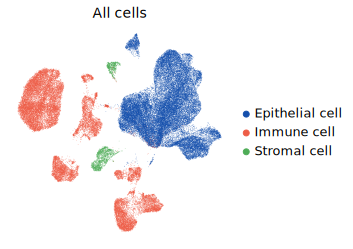

In [32]:
# 1B
# UMAP of all the cells
fig = sc.pl.embedding(adata_all, basis = 'X_umap_all',
                      color = 'cell_type_coarse', 
                      ncols = 3, legend_loc = 'right margin', size = 1,
                      frameon = False, return_fig=True,
                      title = 'All cells')

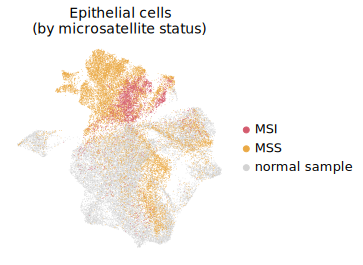

In [33]:
# 1C
# UMAP of epi cells by MS
fig = sc.pl.embedding(adata_epi, basis = 'X_umap_epi', 
                      color=['MS_status_normal'],
                      ncols=1, legend_loc='right margin', size = 2,
                      frameon = False,return_fig=True,
                      title = 'Epithelial cells\n(by microsatellite status)')

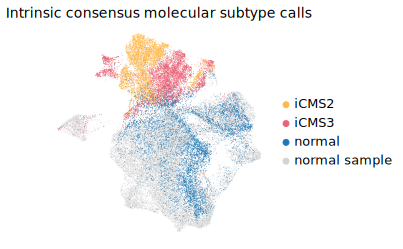

In [34]:
# 1D
# UMAP of epi cells by iCMS calls
fig = sc.pl.embedding(adata_epi, basis = 'X_umap_epi', 
                      color=['iCMS_call_normal'],
                      ncols=1, legend_loc='right margin', size = 2,
                      title = 'Intrinsic consensus molecular subtype calls', 
                      frameon = False, return_fig=True)


In [35]:
# dataframe for 1E
iCMS_and_inferCNV = adata_epi.obs[['inferCNV_call_normal', 'iCMS_call_normal',
                                   'sample_cap', 'sample_origin']]

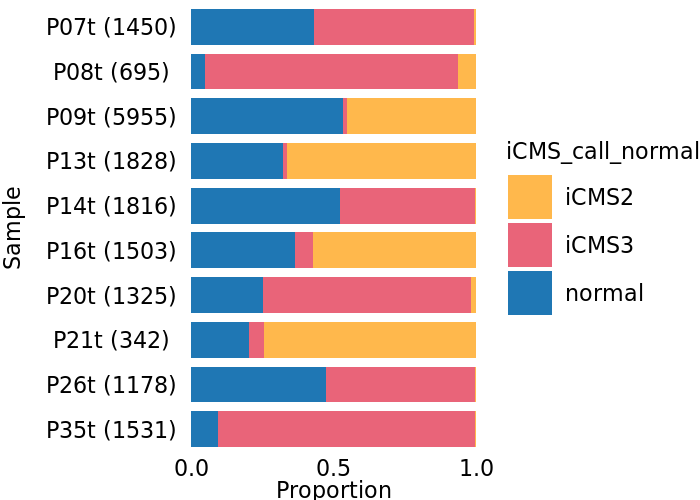

In [36]:
%%R -i iCMS_and_inferCNV -w 700 -h 500 -r 200

# 1E
# bar plot of iCMS result per tumour sample

df = iCMS_and_inferCNV %>%
filter(sample_origin != 'normal') %>%
group_by(sample_cap, iCMS_call_normal) %>%
mutate(sum=n()) %>%
group_by(sample_cap) %>%
mutate(sum_sample = n()) %>%
distinct(sample_cap, iCMS_call_normal, sum, sum_sample) %>%
arrange(sample_cap)


p = df %>%
ggplot(aes(x = sum, y = sample_cap, fill = iCMS_call_normal)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = c('#FFB84C', 
                             '#E96479',
                             '#1f77b4'
                            )) +
theme_void() +
plot_theme_font_size(8) +
theme(axis.title.y = element_text(angle = 90, family = "dajavu sans")) +
labs(x = 'Proportion', 
     y = 'Sample\n') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,labels = paste0(rev(unique(df$sample_cap)), 
                                              ' (', rev(unique(df$sum_sample)), ')'))

print(p)

#ggsave(file="iCMS_bar.svg", width = 8, height = 5, units = "cm", dpi = 300)

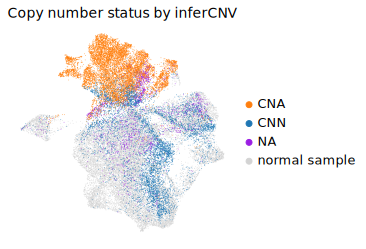

In [37]:
# 1F
# UMAP of epi cells by inferCNV calls
fig = sc.pl.embedding(adata_epi, basis = 'X_umap_epi', 
                      color=['inferCNV_call_normal'],
                      ncols=1, legend_loc='right margin', size = 2,
                      title = 'Copy number status by inferCNV', 
                      frameon = False, return_fig=True)


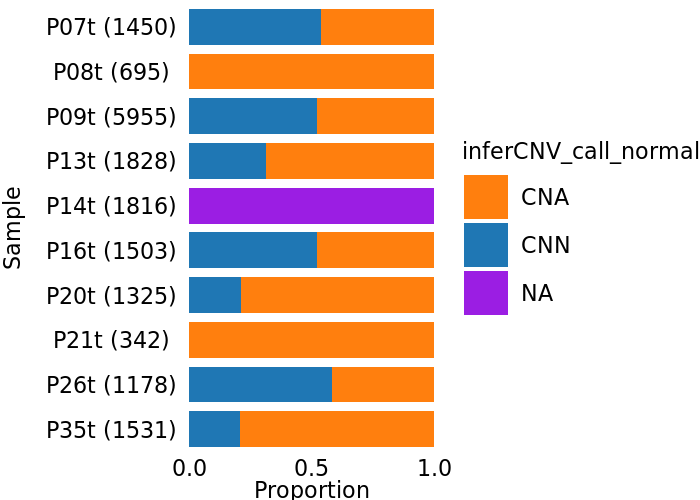

In [38]:
%%R -w 700 -h 500 -r 200

# 1G
# bar plot of inferCNV call per sample

df = iCMS_and_inferCNV %>%
filter(sample_origin != 'normal') %>%
group_by(sample_cap, inferCNV_call_normal) %>%
mutate(sum=n()) %>%
group_by(sample_cap) %>%
mutate(sum_sample = n()) %>%
distinct(sample_cap, inferCNV_call_normal, sum, sum_sample) %>%
arrange(sample_cap)


p = df %>%
ggplot(aes(x = sum, y = sample_cap, fill = inferCNV_call_normal)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = c('#ff7f0e', 
                             '#1f77b4',
                             '#9b1ee3'
                            )) +
theme_void() +
plot_theme_font_size(8) +
theme(axis.title.y = element_text(angle = 90)) +
labs(x = 'Proportion', 
     y = 'Sample\n') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,labels = paste0(rev(unique(df$sample_cap)), 
                                              ' (', rev(unique(df$sum_sample)), ')'))


print(p)

#ggsave(file="inferCNV_bar.svg", width = 8, height = 5, units = "cm", dpi = 300)

In [39]:
# dataframe for 1H
upset_df = adata_epi[adata_epi.obs['sample_origin'] == 'tumour'].obs.copy()

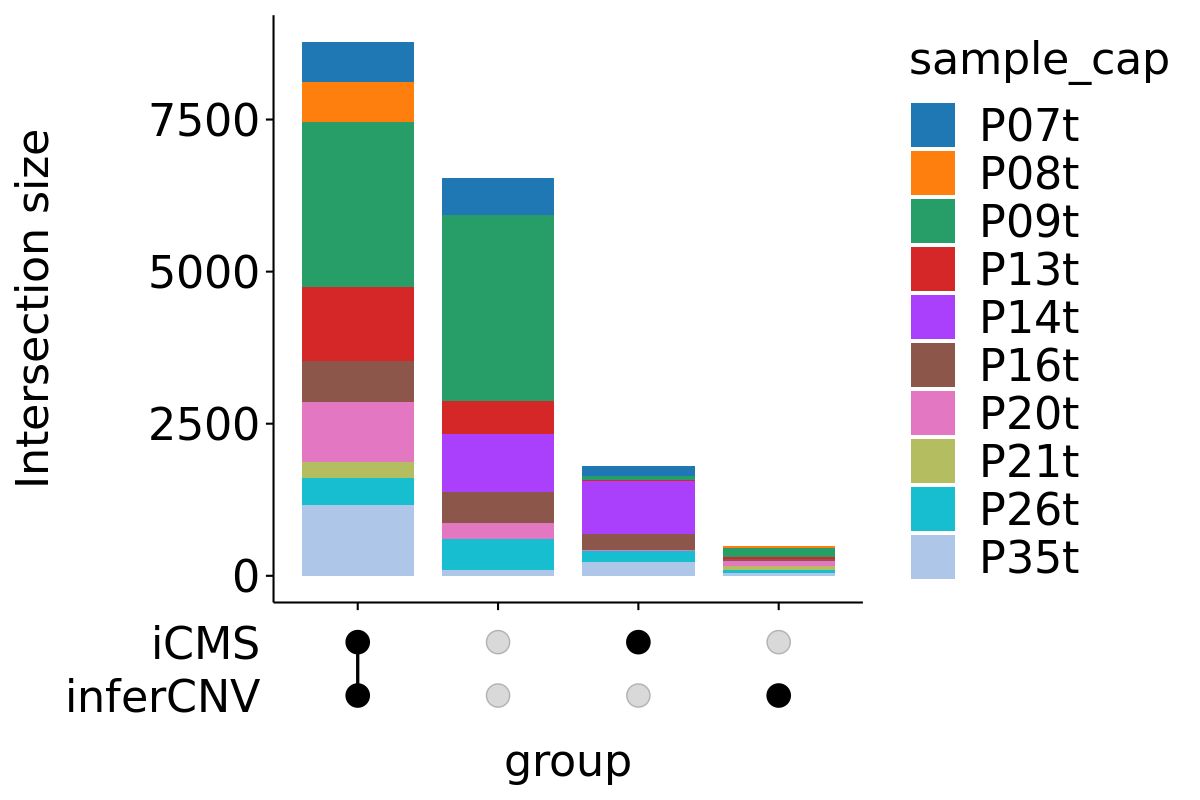

In [40]:
%%R -i upset_df -w 1200 -h 800 -r 200

# 1H
# Upsetplot of calls by inferCNV and iCMS

df = upset_df %>%
select(iCMS_call_normal, inferCNV_call_normal, sample_cap) %>%
mutate(iCMS = ifelse(iCMS_call_normal != 'normal', TRUE, FALSE),
       inferCNV = ifelse(inferCNV_call_normal == 'CNA', TRUE, FALSE)) 

p = upset(df, c('iCMS', 'inferCNV'), 
      #name = 'tumour calls by iCMS and inferCNV', 
      set_sizes = FALSE, height_ratio = 1/5,
      stripes = upset_stripes(
          colors = 'white'),
          base_annotations = list('Intersection size' = intersection_size(
                                                      counts = FALSE, 
          mapping = aes(fill = sample_cap), width = 0.8) +
                                  scale_fill_manual(values = c('#1f77b4', '#ff7f0e', '#279e68', '#d62728', 
                                                            '#aa40fc', '#8c564b',
                                                            '#e377c2', '#b5bd61', '#17becf', '#aec7e8')) +
                              theme(panel.grid = element_blank(),
                                    axis.ticks = element_line('black'),
                                    axis.line = element_line()) + 
                              plot_theme_font_size(16)
                             )) + 
theme(panel.grid = element_blank())+
plot_theme_font_size(16) 

print(p)

#ggsave(file="iCMS_inferCNV_upset_by_pt.svg", width = 10, height = 10, units = "cm", dpi = 300)

### Figure 2ABCDE
#### referred to ./Fig2_simulations.Rmd
- A: Scatter plot of number of SNVs in WGS data versus mean number of SNVs in single-cell RNA sequencing datas
- B: CCISM scheme (not here)
- C: Boxplots of benchmarking CCISM against CardelinoEM and Vireo
- D: Scatter plot of the effect of (upper) the percentage of tumour content and (lower) the mean number of SNVs on the tool performance 
- E: Scatter plot of the effect of subsampling on TPR

In [48]:
%%R 

# function
get_cellSNP_output <- function(dir, prefix='') {
  cells <- paste0(prefix,readLines(file.path(dir,'cellSNP.samples.tsv')))
  SNPs <- read.table(file.path(dir,'cellSNP.base.vcf'),
                     sep='\t',skip=1,header=1,as.is=TRUE,comment.char='') %>%
    dplyr::mutate(SNP=paste0(X.CHROM,':',POS,REF,'>',ALT)) %>%
    dplyr::pull(SNP)
  A <- readMM(file.path(dir,'cellSNP.tag.AD.mtx'))
  colnames(A) <- cells
  rownames(A) <- SNPs
  D <- readMM(file.path(dir,'cellSNP.tag.DP.mtx'))
  colnames(D) <- cells
  rownames(D) <- SNPs
  list(A=A,D=D)
}

samples <- c(paste0('p0',c('07','08','13','14','16','20','21','26','35'),'t'),
             'p009t1','p009t2')

A.list <- list()
D.list <- list()
for (sample in samples) {
  tmp <- get_cellSNP_output(file.path('..','..','zenodo_repository','cellSNP',sample),
                            prefix='')
  A.list[[sample]] <- tmp[['A']]
  D.list[[sample]] <- tmp[['D']]
}

In [41]:
%%R

# stats
results <- read.csv('Fig2_simulation_results.csv',header=1,row.names=1) %>%
  dplyr::mutate(tool=factor(gsub('cardelino','cardelinoEM',tool),levels=c('CCISM','cardelinoEM','vireo')))
stats <- results %>%
  dplyr::mutate(donor=gsub('[nt][12]*','',sample)) %>%
  dplyr::mutate(call=ifelse(!is.na(p) & (p > .5),'tumor','normal'),
                label=ifelse(as.logical(label),'tumor','normal')) %>%
  dplyr::group_by(sample,donor,frac_tumor,rep,tool) %>%
  dplyr::summarise(TP=sum((call=='tumor') & (label=='tumor'),na.rm=TRUE),
                   FP=sum((call=='tumor') & (label=='normal'),na.rm=TRUE),
                   TN=sum((call=='normal') & (label=='normal'),na.rm=TRUE),
                   FN=sum((call=='normal') & (label=='tumor'),na.rm=TRUE),
                   time=mean(time)) %>%
  dplyr::mutate(FPR=FP/(FP+TN),
                TPR=TP/(TP+FN))

donors <- unique(stats$donor)

donor_colors <- setNames(brewer.pal(length(donors),'Paired'),gsub('p0','P',donors))

tool_colors <- c('CCISM'='forestgreen','vireo'='yellow3','cardelinoEM'='orange3')

`summarise()` has grouped output by 'sample', 'donor', 'frac_tumor', 'rep'. You
can override using the `.groups` argument.


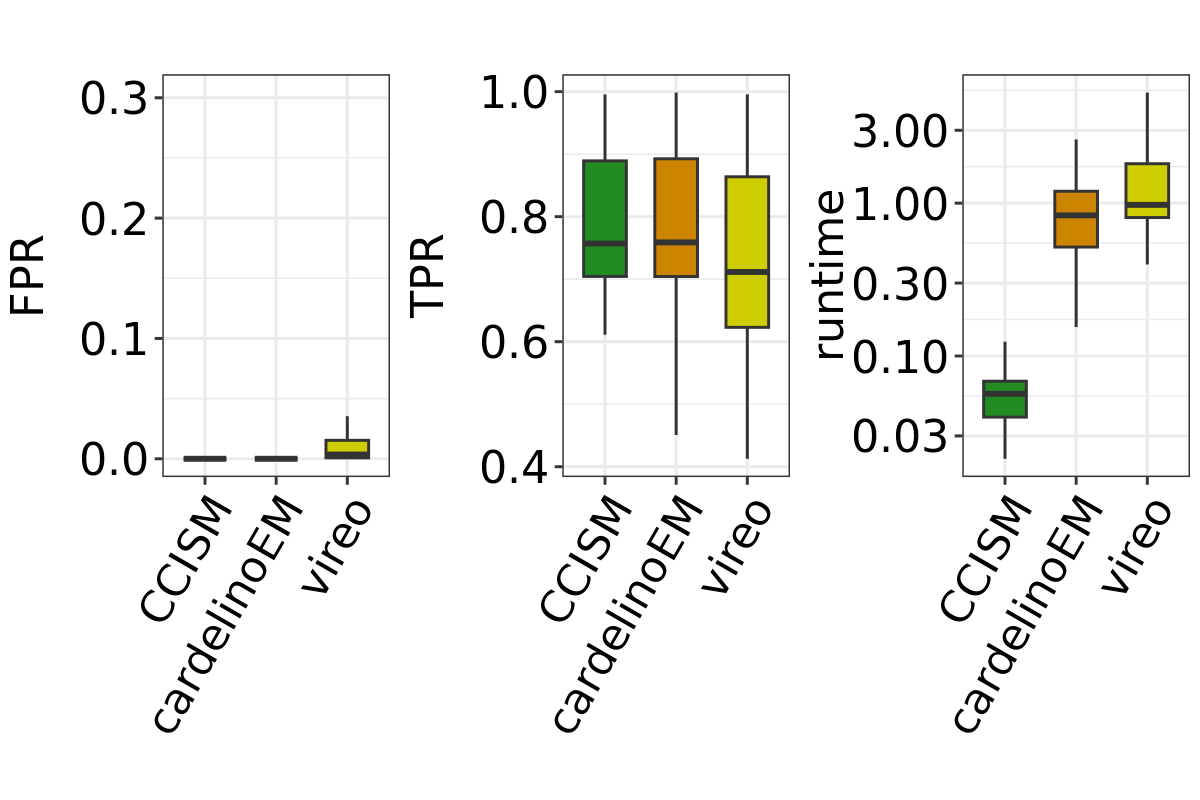

In [44]:
%%R -w 1200 -h 800 -r 200

# 2C
# performance
pl <- lapply(c('FPR','TPR','runtime'), function(x)
  stats %>% 
    dplyr::mutate(runtime=time) %>%
    dplyr::ungroup() %>%
    ggplot(aes_string(x='tool',y=x,fill='tool')) +
    geom_boxplot(position=position_dodge(width=.8),width=.6,outlier.shape=NA) +
    theme_bw() + 
    theme(legend.position='none',
          axis.text.x=element_text(angle=60,hjust=1,vjust=1),
          plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    scale_fill_manual(values=tool_colors) +
    labs(x='',y=x,title='') + 
    plot_theme_font_size(16))

plot_grid(plotlist=list(pl[[1]],pl[[2]],pl[[3]] + scale_y_log10()), 
          ncol=3, align='vh', scale=.95)

`summarise()` has grouped output by 'frac_tumor', 'tool'. You can override
using the `.groups` argument.


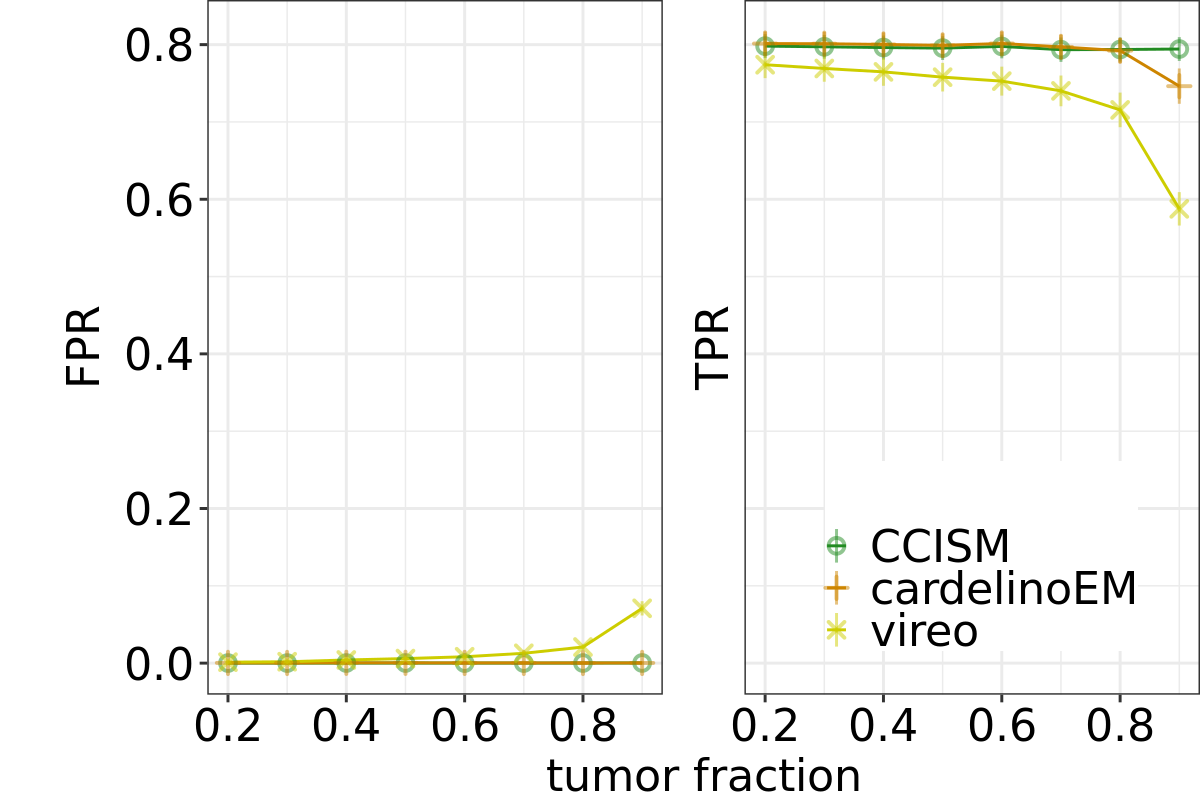

In [45]:
%%R -w 1200 -h 800 -r 200

# 2D upper
# dependence on tumour fraction
ggplot(stats %>% 
         dplyr::ungroup() %>%
         dplyr::select(frac_tumor,tool,FPR,TPR) %>%
         gather(metric,value,-c(frac_tumor,tool)) %>%
         dplyr::group_by(frac_tumor,tool,metric) %>%
         dplyr::summarise(mean=mean(value,na.rm=TRUE),
                          se=sd(value,na.rm=TRUE)/sqrt(n())),
       aes(x=frac_tumor,y=mean,ymin=mean-se,ymax=mean+se,color=tool)) +
  geom_line(aes(group=tool),size=.5) +
  geom_pointrange(aes(shape=tool),fatten=4,alpha=.5) +
  theme_bw() + 
  facet_wrap(~metric,ncol=2,switch='y') + #,scales='free') +
  scale_color_manual(values=tool_colors) +
  scale_shape_manual(values=c(1,3,4),guide=FALSE) +
  guides(color=guide_legend(override.aes=list(shape=c(1,3,4)))) +
  labs(x='tumor fraction',y='',color='') +
  theme(legend.position=c(.78,.2),
        legend.margin=unit(0,'mm'),
        legend.title=element_blank(),
        strip.background = element_rect(color = "black", fill=NA, size = 0),
        legend.key.size=unit(3,'mm'),
        strip.placement='outside')  +
  plot_theme_font_size(16) 

`summarise()` has grouped output by 'sample', 'nSNPs_tot', 'frac_tumor', 'rep'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'nSNPs_tot', 'metric'. You can override
using the `.groups` argument.


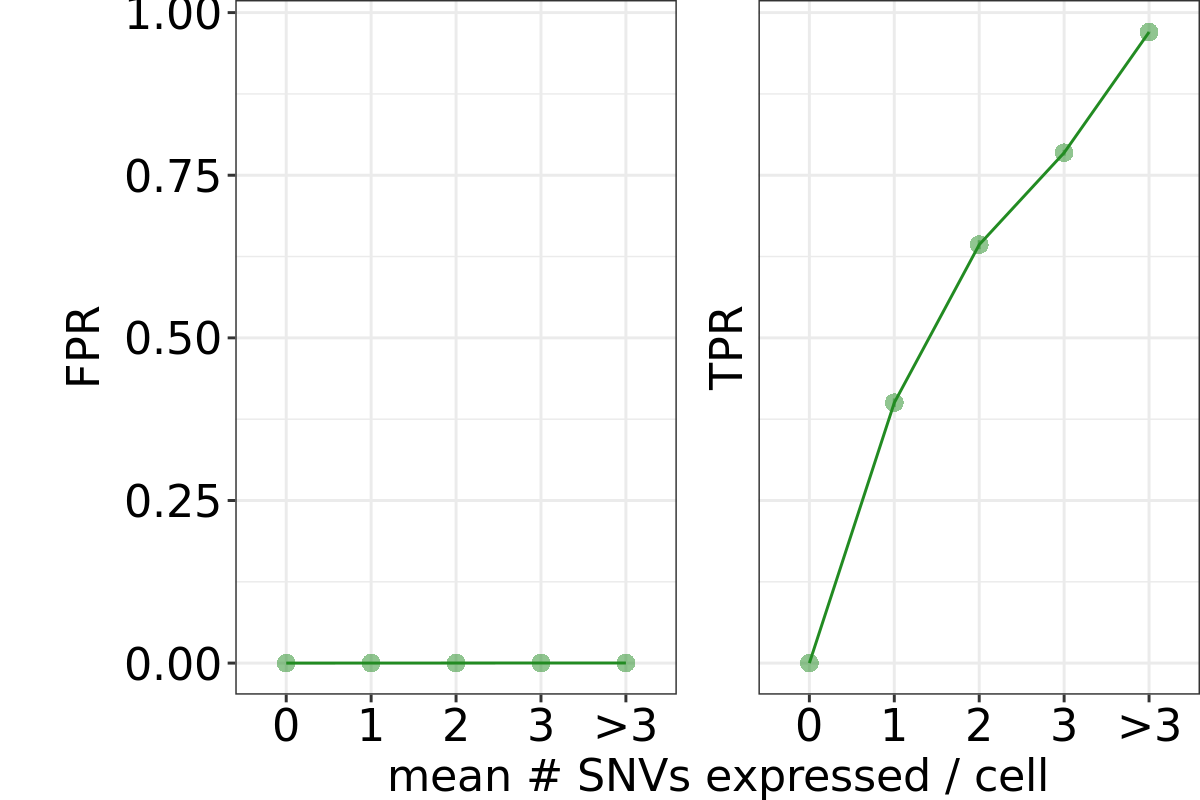

In [46]:
%%R -w 1200 -h 800 -r 200

# 2D lower
# dependence on number of SNVs
stats_by_nSNPs <- results %>%
  dplyr::mutate(nSNPs_tot=cut(nSNPs_tot,c(-1,0,1,2,3,10000),labels=c(0,1,2,3,'>3'),include.lowest=TRUE)) %>%
  dplyr::group_by(sample,nSNPs_tot,frac_tumor,rep,tool) %>%  
  dplyr::mutate(call=ifelse(!is.na(p) & (p > .5),'tumor','normal'),
                label=ifelse(as.logical(label),'tumor','normal')) %>%
  dplyr::summarise(TP=sum((call=='tumor') & (label=='tumor'),na.rm=TRUE),
                   FP=sum((call=='tumor') & (label=='normal'),na.rm=TRUE),
                   TN=sum((call=='normal') & (label=='normal'),na.rm=TRUE),
                   FN=sum((call=='normal') & (label=='tumor'),na.rm=TRUE)) %>%
  dplyr::mutate(FPR=FP/(FP+TN),
                TPR=TP/(TP+FN))
  
ggplot(stats_by_nSNPs %>%
         dplyr::mutate(donor=gsub('t[12]*$','',sample)) %>%
         dplyr::select(-c(TP,FP,TN,FN)) %>%
         gather(metric,value,-c(donor,nSNPs_tot,frac_tumor,sample,rep,tool)) %>%
         dplyr::group_by(nSNPs_tot,metric,tool) %>%
         dplyr::summarise(mean=mean(value,na.rm=TRUE),
                          se=sd(value,na.rm=TRUE)/sqrt(n())) %>%
         dplyr::filter(tool=='CCISM'),
       aes(x=nSNPs_tot,y=mean,ymin=mean-se,ymax=mean+se,color=tool)) + 
  geom_line(aes(group=tool),size=.5) +
  geom_pointrange(aes(shape=tool),fatten=5,alpha=.5) +
  facet_wrap(~metric,ncol=2,switch='y') +
  scale_color_manual(values=tool_colors) +
  labs(x='mean # SNVs expressed / cell',y='',fill='',color='',shape='') +
  theme_bw() +
  theme(legend.position='none',
        legend.margin=unit(0,'mm'),
        legend.title=element_blank(),
        strip.background = element_rect(color = "black", fill=NA, size = 0),
        legend.key.size=unit(3,'mm'),
        strip.placement='outside') +
  plot_theme_font_size(16) 


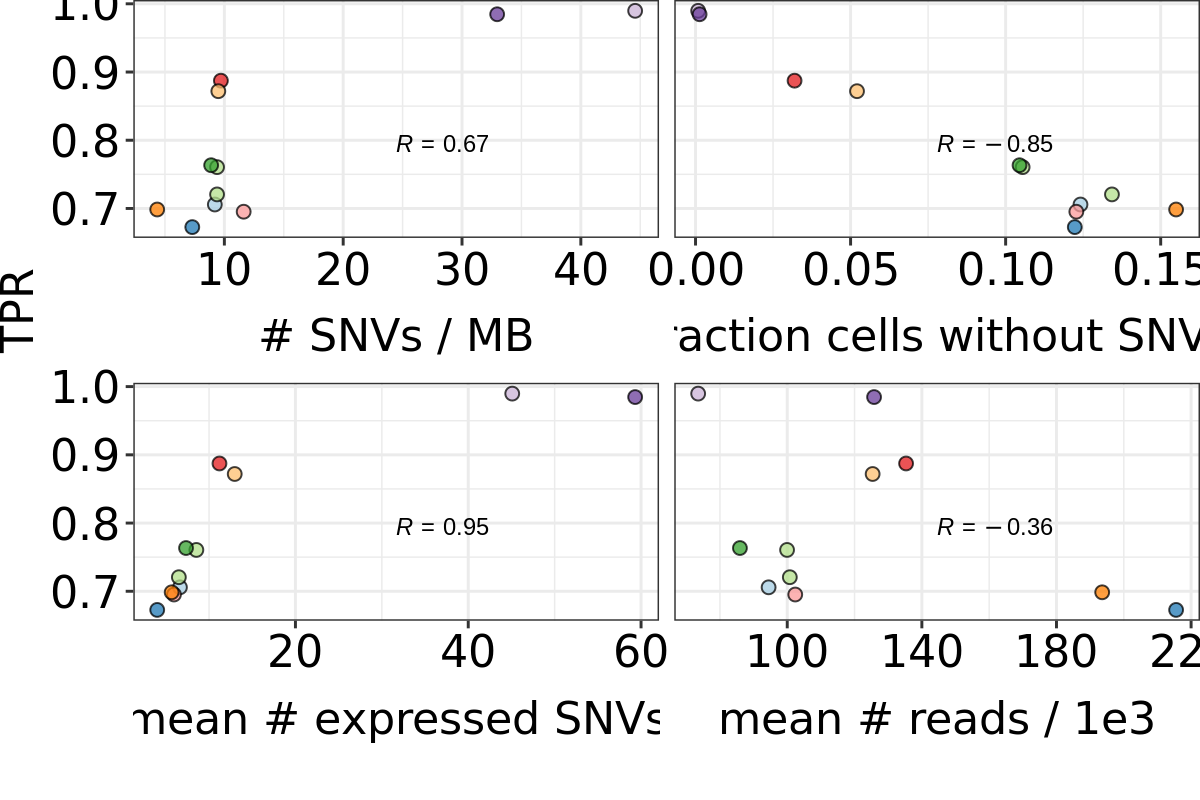

In [49]:
%%R -w 1200 -h 800 -r 200

# stats
# statistics on number of cells, total number of reads and mitochondrial reads derived from bam files
mito_fraction <- 'sample   ncells  total   mito
p007n   1177    184945934       79323177
p007t   1450    136970642       33555196
p008n   1086    200646765       78176181
p008t   695     149803413       33273405
p009n1  2803    220252457       76150649
p009n2  4169    269516540       86884306
p009t1  3016    303907866       70802986
p009t2  2939    293744398       54816472
p013n   1823    91076301        35990361
p013t   1828    157094509       26441692
p014n   2572    198361475       68434824
p014t   1816    185911112       45072742
p016n   3337    192613273       56219217
p016t   1503    203371623       38232139
p020n   2107    122603691       39780454
p020t   1325    166118777       25879507
p021n   2471    183074042       66372613
p021t   342     66204346        11930544
p026t   1178    86617500        18221950
p035t   1531    192599285       43134909'
depth <- read.csv(text=mito_fraction,sep="",header=1) %>%
  dplyr::mutate(mean_reads=total/ncells/1.e3) 

# get number of somatic variants using the script `get_num_variants.sh`
num_variants <- read.csv('num_variants.txt',sep='',header=1) %>%
  dplyr::mutate(variants_per_MB=nvars/3100.)  %>%
  dplyr::select(-nvars)

dataset_stats <- lapply(names(D.list), function(x) data.frame(mean_nSNVs_tot=mean(colSums(D.list[[x]] > 0)),
                                                              fraction_uninformative=mean(colSums(D.list[[x]] > 0)==0),
                                                              sample=x)) %>%
  do.call(rbind,.) %>%
  dplyr::mutate(donor=gsub('t[12]*$','',sample)) %>%
  dplyr::left_join(depth,by='sample') 

var_names <- c('fraction_uninformative'='fraction cells without SNVs',
               'mean_nSNVs_tot'='mean # expressed SNVs',
               'mean_reads'='mean # reads / 1e3',
               'variants_per_MB'='# SNVs / MB')
tmp <- dplyr::left_join(stats %>%   
                   dplyr::group_by(donor,sample,frac_tumor,tool) %>%
                   dplyr::summarise_if(is.numeric,mean) %>%
                   dplyr::ungroup() %>%
                   dplyr::filter(frac_tumor==.5,tool=='CCISM') %>%
                   dplyr::select(-c(TP,FP,TN,FN,frac_tumor,rep,tool)),
                 dataset_stats %>%
                   dplyr::left_join(num_variants,by=c('donor')),
                 by=c('donor','sample')) 

tmp %>% 
  gather(variable,value,c(mean_nSNVs_tot,fraction_uninformative,mean_reads,variants_per_MB)) %>%
  dplyr::mutate(variable=factor(plyr::revalue(variable,var_names),
                                levels=c('# SNVs / MB',
                                         'fraction cells without SNVs',
                                         'mean # expressed SNVs',
                                         'mean # reads / 1e3')),
                donor=gsub('p0','P',donor)) %>%
  ggplot(aes(x=as.numeric(value),y=TPR)) + 
  geom_point(aes(fill=donor),pch=21,size=2,alpha=.75) +
  facet_wrap(~variable,ncol=2,scales='free_x',strip.position = "bottom") +
  theme_bw() + 
  guides(fill=guide_legend(override.aes=list(pch=21,stroke=.5,size=3))) +
  theme(legend.key.size=unit(3,'mm'),
        legend.title=element_blank(),
        strip.background = element_rect(color = "black", fill=NA, size = 0),
        legend.position='none',
        strip.placement = "outside") +
  scale_fill_manual(values=donor_colors) +
  stat_cor(aes(label = ..r.label..), method = "spearman", label.x.npc=.5, label.y.npc=.4,  size=3) +
  labs(x='',color='',shape='',fill='',y='TPR') +
  plot_theme_font_size(16) 


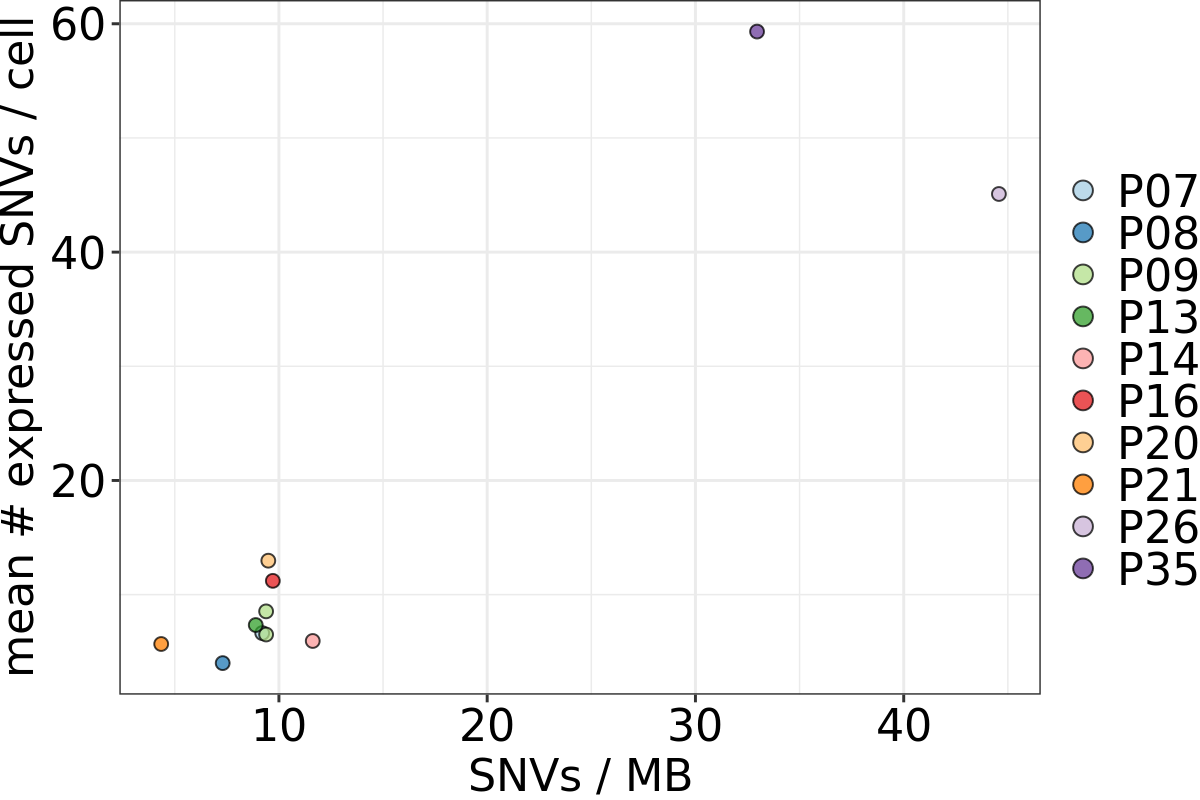

In [50]:
%%R -w 1200 -h 800 -r 200

# 2A
# expressed SNVs 
ggplot(tmp %>% dplyr::mutate(donor=gsub('p0','P',donor)), 
       aes(x=variants_per_MB,y=mean_nSNVs_tot)) +
  geom_point(aes(fill=donor),size=2,alpha=.75,pch=21) +
  theme_bw() + 
  theme(legend.key.size=unit(3,'mm'),
        legend.title=element_blank(),
        legend.margin=unit(3,'mm'),
        legend.position='right',
        legend.box='vertical') +
  scale_fill_manual(values=donor_colors) +
  guides(fill=guide_legend(override.aes=list(pch=21,stroke=.5,size=3),ncol=1)) +
  labs(x='SNVs / MB', y='mean # expressed SNVs / cell', color='',shape='',fill='') + 
  plot_theme_font_size(16) 


`summarise()` has grouped output by 'sample', 'frac'. You can override using
the `.groups` argument.


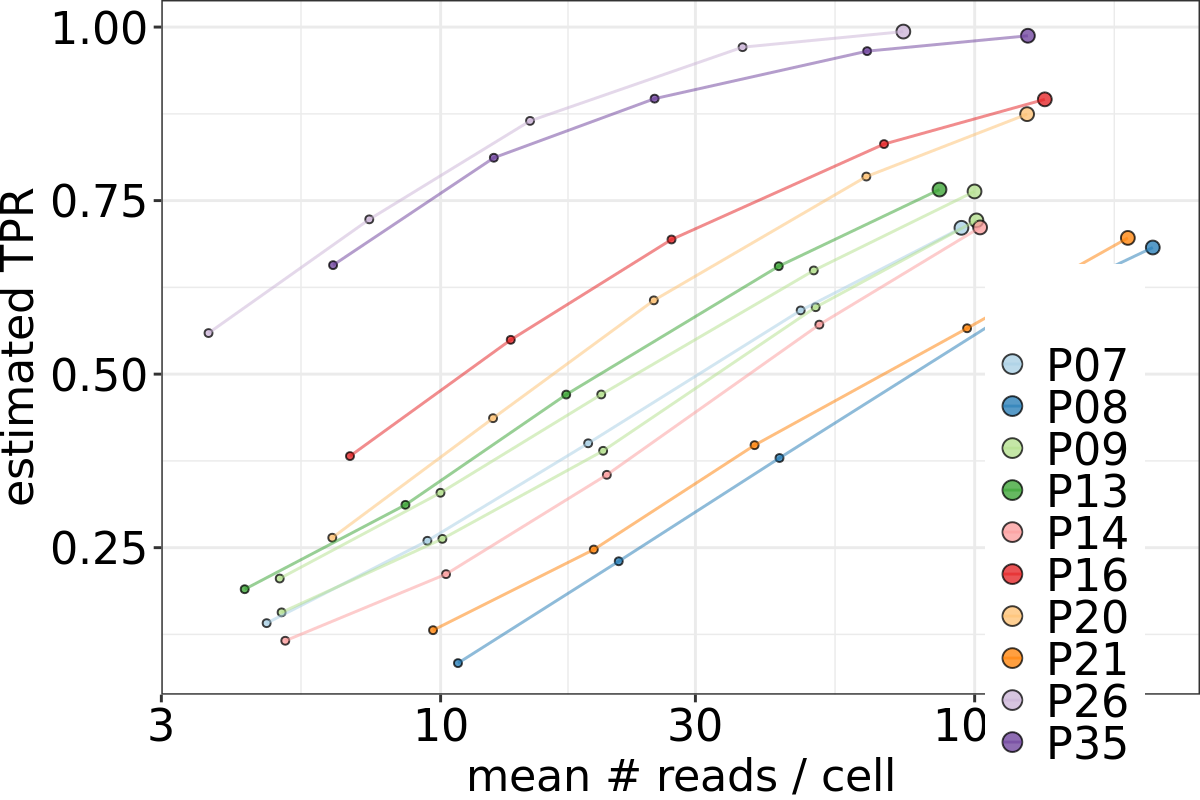

In [51]:
%%R -w 1200 -h 800 -r 200

# 2E
# subsampling
power.files <- list()
for (sample in samples) {
  for (frac in c('_05','_1','_2','_5','')) {
    power <- list()
    for (samp in paste0(sample,c('','1','2'),frac)) {
      power_file <- file.path('..','..','zenodo_repository','CCISM',samp,'power_estimates.txt')
      if (file.exists(power_file)) { 
        power[[samp]] <- read.table(power_file,header=1,sep='\t') %>%
          dplyr::mutate(frac=ifelse(frac=='',1,as.numeric(paste0("0.",gsub('_','',frac)))),
                        donor=gsub('[nt]+[0-9]*$','',sample),
                        sample=samp)
      }
    }
    if (length(power) > 0) {
      power.files[[paste0(sample,'_',frac)]] <- do.call(rbind,power)
    }
  }
}

power <- do.call(rbind,power.files) %>%
  dplyr::group_by(sample,frac,donor) %>%
  dplyr::summarise(est_TPR=mean(TPR),
                   est_FPR=mean(FPR)) %>%
  dplyr::mutate(sample=gsub('_.*','',sample))

dplyr::left_join(power,dataset_stats,by=c('donor','sample')) %>%
  dplyr::mutate(mean_reads=mean_reads*as.numeric(frac),
                donor=gsub('p0','P',donor)) %>%
  ggplot(aes(x=mean_reads,y=est_TPR)) + 
  geom_point(aes(fill=donor,size=ifelse(frac==1,'real','subsampled')),alpha=.75,pch=21) +
  geom_line(aes(color=donor,group=sample),size=.5,alpha=.5) +
  theme_bw() + 
  guides(fill=guide_legend(override.aes=list(pch=21,stroke=.5,size=3),ncol=1)) +
  theme(legend.key.size=unit(3,'mm'),
        legend.title=element_blank(),
        strip.background = element_rect(color = "black", fill=NA, size = 0),
        legend.position=c(.87,.25),
        strip.placement = "outside") +
  scale_fill_manual(values=donor_colors) +
  scale_size_manual(values=c('real'=2,'subsampled'=1),guide=NULL) +
  scale_color_manual(values=donor_colors) +
  scale_x_log10() +
  #stat_cor(aes(label = ..r.label..), method = "spearman", label.x.npc=.8, label.y.npc=.98,  size=4) +
  labs(x='mean # reads / cell',color='',shape='',fill='',y='estimated TPR') +
  plot_theme_font_size(16) 

### Figure 3ABCDEFGH
- A: UMAP of CCISM calls
- B: UMAP of Numbat calls
- C: Venn diagram of iCMS, inferCNV, CCISM, and Numbat calls
- D: Upsetplot of CCISM and Numbat calls
- E: Stacked barplots of CCISM and Numbat call scores 
- F: Decision matrix of the consensus cancer call by CCISM and Numbat result (not here)
- G. Bar plot of consensus calls across patients
- H. UMAP of consensus calls 

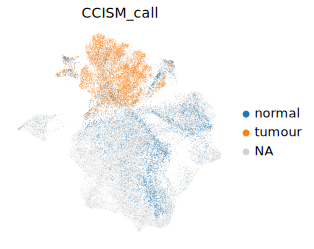

In [53]:
# 3A
fig = sc.pl.embedding(adata_epi, basis='X_umap_epi',
                      color=['CCISM_call'],
                 ncols=1, legend_loc='right margin', size = 1, 
                 frameon = False,return_fig=True)

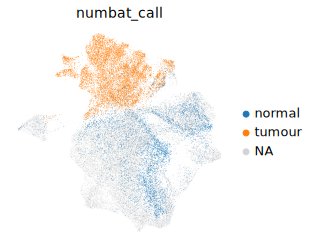

In [54]:
# 3B
fig = sc.pl.embedding(adata_epi, color=['numbat_call'],
                      basis='X_umap_epi',
                 ncols=1, legend_loc='right margin', size = 1, 
                 frameon = False,return_fig=True)

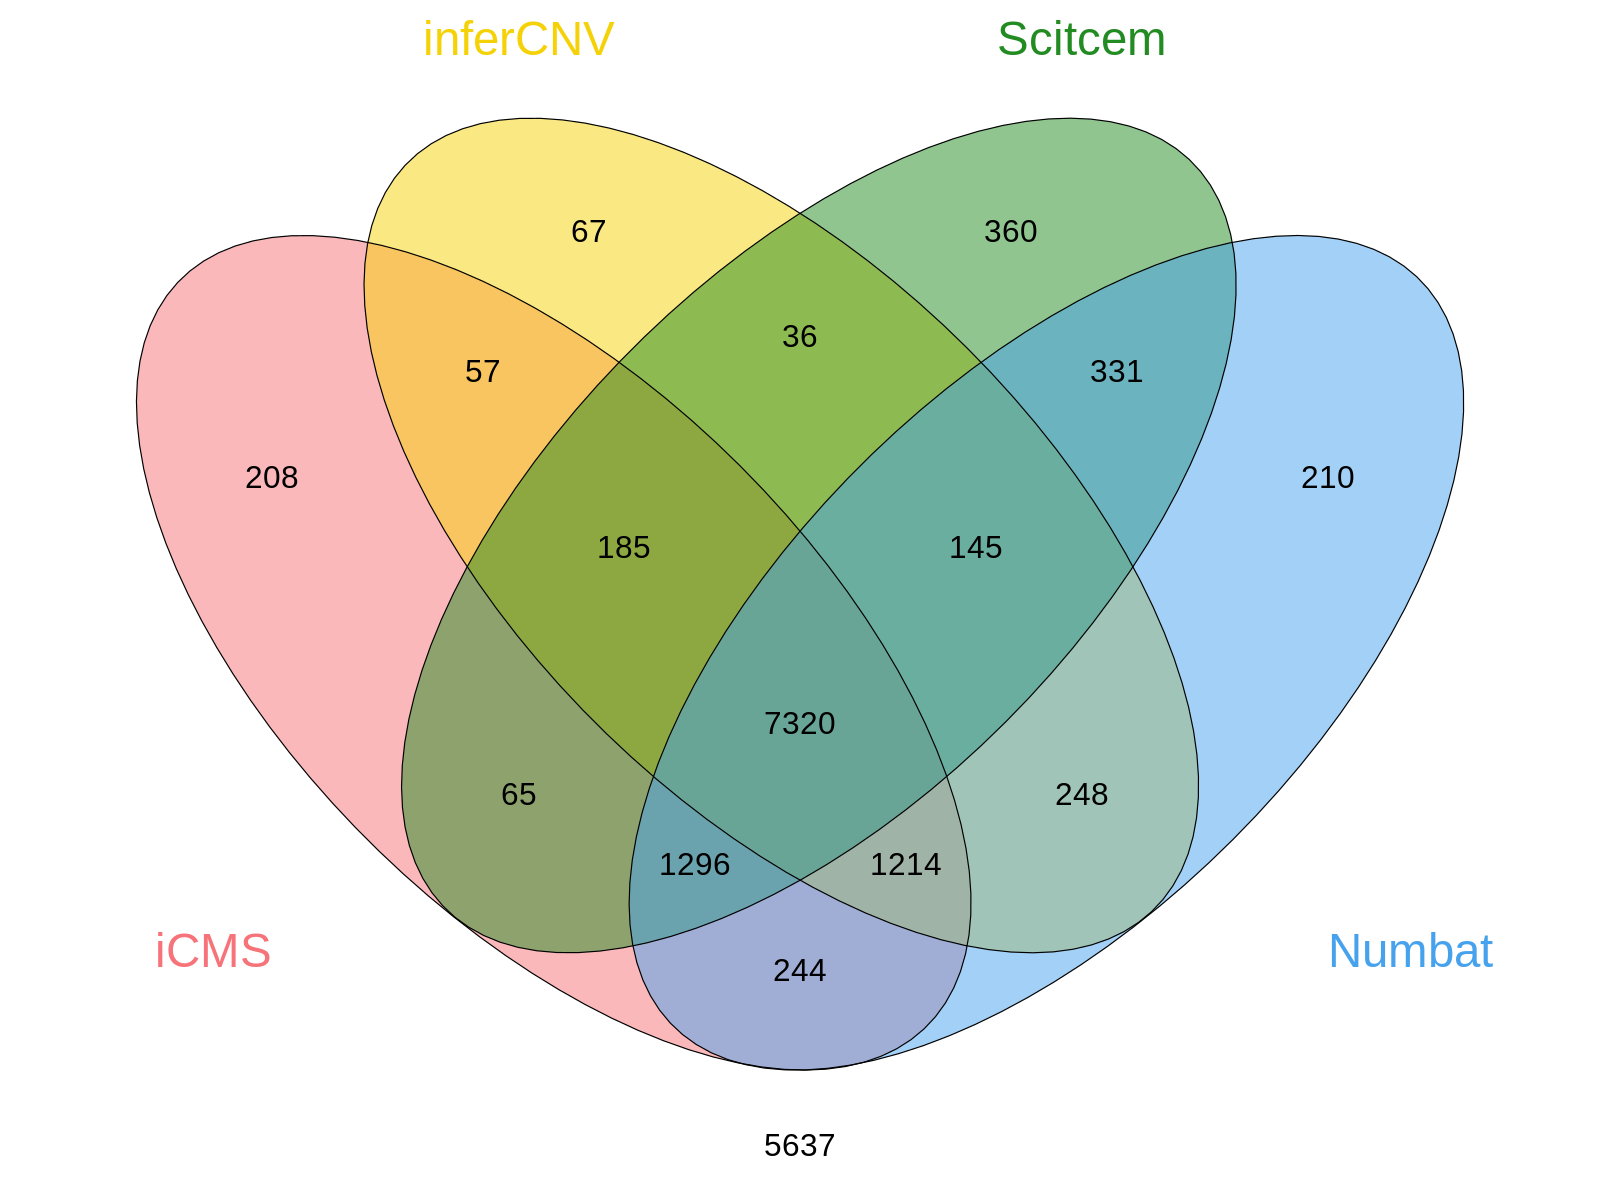

In [77]:
%%R -w 1600 -h 1200 -r 200

# 3C

method_colors = c('#f57379','#f5d107', '#228b22', '#47a2ed')

df = upset_df %>%
dplyr::select(CCISM_call, numbat_call, inferCNV_call_normal, iCMS_call, MS_status) %>%
dplyr::mutate(iCMS = ifelse(iCMS_call != 'normal', TRUE, FALSE),
       inferCNV = ifelse(inferCNV_call_normal == 'CNA', TRUE, FALSE),
       Scitcem = ifelse(CCISM_call == 'tumour', TRUE, FALSE),
       Numbat = ifelse(numbat_call == 'tumour', TRUE, FALSE)) 


p=ggvenn(df, stroke_size = 0.2, set_name_size = 6, show_percentage = FALSE,
       fill_alpha = 0.5,
       set_name_color = method_colors,
       fill_color = method_colors) +
plot_theme_font_size(20)+
theme(axis.text = element_blank(),
     axis.title = element_blank())

print(p)

#ggsave(file="venn.svg", width = 20, height = 20, units = "cm", dpi = 300)

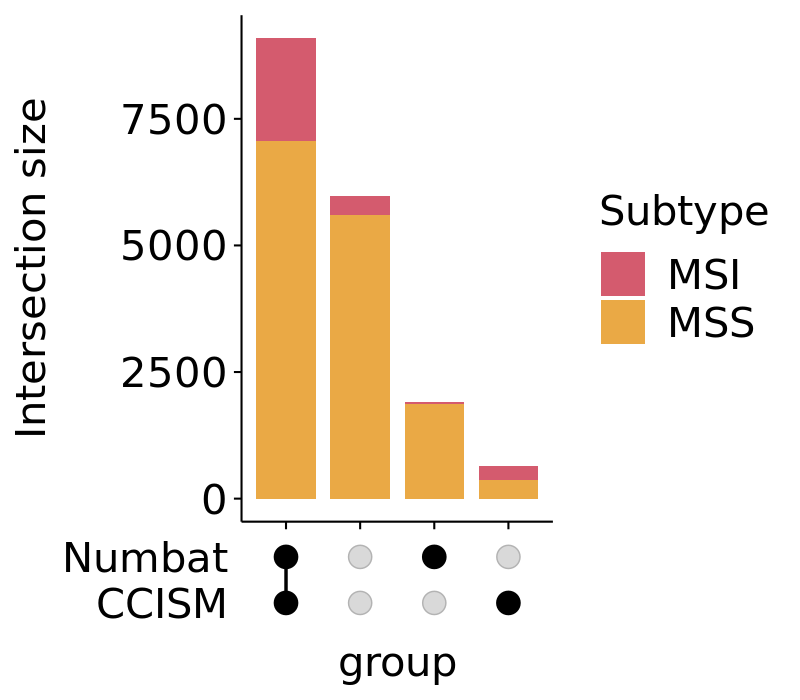

In [81]:
%%R -w 800 -h 700 -r 200

# 3D

df = upset_df %>%
select(CCISM_call, numbat_call, MS_status) %>%
mutate(CCISM = ifelse(CCISM_call == 'tumour', TRUE, FALSE),
       Numbat = ifelse(numbat_call == 'tumour', TRUE, FALSE)) 

p = upset(df, c('CCISM', 'Numbat'),
          set_sizes = FALSE, height_ratio = 1/5,sort_sets=FALSE,
          stripes = upset_stripes(
              colors = 'white'
          ),
          base_annotations = list('Intersection size' = intersection_size(
                                                      counts = FALSE, mapping = aes(fill = MS_status), width = 0.8) +
                              scale_fill_manual(values = c('#D45B6E', '#EAA945'), name = 'Subtype') +
                              theme(panel.grid = element_blank(),
                                    axis.ticks = element_line('black'),
                                    axis.line = element_line()) + 
                              plot_theme_font_size(15)
                             )) + 
theme(panel.grid = element_blank())+
plot_theme_font_size(15)

print(p)

#ggsave(file="Numbat_CCISM_upset_by_MS.svg", width = 10, height = 10, units = "cm", dpi = 300)


# dont use theme_void(), there is something hidden in their code that will show some random texts


In [ ]:
# cell identities not agreed by all four tools:
17623-7320-5637

In [ ]:
# 1296 cell inferCNV normal
inferCNV_only_normal_cells = adata_epi[(adata_epi.obs['sample_origin'] == 'tumour\nsample') &
         (adata_epi.obs['scitcem_call'] == 'tumour\n(tumour sample)') &
         (adata_epi.obs['numbat'] == 'tumour\n(tumour sample)') &
         (adata_epi.obs['inferCNV_result'] != 'CNA\n(tumour sample)') &
         (adata_epi.obs['iCMS_scANVI'] != 'normal\n(tumour sample)')]

In [ ]:
inferCNV_only_normal_cells.obs['sample_cap'].value_counts().sort_index()

In [ ]:
inferCNV_only_normal_cells.obs[['sample_cap','clone_opt']].value_counts().sort_index()

In [ ]:
# 1214 cell Scitcem normal
scitcem_only_normal_cells = adata_epi[(adata_epi.obs['sample_origin'] == 'tumour\nsample') &
         (adata_epi.obs['scitcem_call'] != 'tumour\n(tumour sample)') &
         (adata_epi.obs['numbat'] == 'tumour\n(tumour sample)') &
         (adata_epi.obs['inferCNV_result'] == 'CNA\n(tumour sample)') &
         (adata_epi.obs['iCMS_scANVI'] != 'normal\n(tumour sample)')]

In [ ]:
scitcem_only_normal_cells.obs['sample_cap'].value_counts().sort_index()

In [ ]:
scitcem_only_normal_cells.obs[['filter_dp','filter_alt']].value_counts()

In [ ]:
scitcem_only_normal_cells.obs['filter_alt'].value_counts()

In [ ]:
# 208 iCMS only tumour cell
iCMS_only_tumour_cells = adata_epi[(adata_epi.obs['sample_origin'] == 'tumour\nsample') &
         (adata_epi.obs['scitcem_call'] != 'tumour\n(tumour sample)') &
         (adata_epi.obs['numbat'] != 'tumour\n(tumour sample)') &
         (adata_epi.obs['inferCNV_result'] != 'CNA\n(tumour sample)') &
         (adata_epi.obs['iCMS_scANVI'] != 'normal\n(tumour sample)')]

In [ ]:
iCMS_only_tumour_cells.obs['sample_cap'].value_counts().sort_index()

In [ ]:
iCMS_only_tumour_cells.obs['filter_alt'].value_counts()

In [ ]:
iCMS_only_tumour_cells.obs['clone_opt'].value_counts()

In [ ]:
iCMS_only_tumour_cells.obs['Uhlitz_scANVI'].value_counts().sort_index()

In [ ]:
adata_epi.obs['icms_only_tumour_cells'] = adata_epi.obs.index.isin(iCMS_only_tumour_cells.obs.index.values)

In [ ]:
scv.pl.scatter(adata_epi, basis='umap', color='icms_only_tumour_cells', 
               ncols=1, legend_loc='right margin', size = 2)

In [ ]:
# 67 inferCNV only tumour cell
inferCNV_only_tumour_cells = adata_epi[(adata_epi.obs['sample_origin'] == 'tumour\nsample') &
         (adata_epi.obs['scitcem_call'] != 'tumour\n(tumour sample)') &
         (adata_epi.obs['numbat'] != 'tumour\n(tumour sample)') &
         (adata_epi.obs['inferCNV_result'] == 'CNA\n(tumour sample)') &
         (adata_epi.obs['iCMS_scANVI'] == 'normal\n(tumour sample)')]

In [ ]:
inferCNV_only_tumour_cells.obs['sample_cap'].value_counts().sort_index()

In [ ]:
inferCNV_only_tumour_cells.obs['filter_alt'].value_counts().sort_index()

In [ ]:
inferCNV_only_tumour_cells.obs[['sample_cap','clone_opt', 'filter_alt']].value_counts().sort_index()

In [ ]:
# 57 inferCNV and iCMS only tumour cell
inferCNV_and_iCMS_tumour_cells = adata_epi[(adata_epi.obs['sample_origin'] == 'tumour\nsample') &
         (adata_epi.obs['scitcem_call'] != 'tumour\n(tumour sample)') &
         (adata_epi.obs['numbat'] != 'tumour\n(tumour sample)') &
         (adata_epi.obs['inferCNV_result'] == 'CNA\n(tumour sample)') &
         (adata_epi.obs['iCMS_scANVI'] != 'normal\n(tumour sample)')]

In [ ]:
inferCNV_and_iCMS_tumour_cells.obs['filter_alt'].value_counts().sort_index()

In [ ]:
inferCNV_and_iCMS_tumour_cells.obs[['sample_cap','clone_opt', 'filter_alt']].value_counts().sort_index()

In [ ]:
inferCNV_and_iCMS_tumour_cells.obs['Uhlitz_scANVI'].value_counts().sort_index()

In [ ]:
adata_epi.obs[['inferCNV_result', 'iCMS_scANVI']].value_counts(dropna=False).sort_index()

In [85]:
upset_df = adata_epi[adata_epi.obs['sample_origin'] == 'tumour'].obs

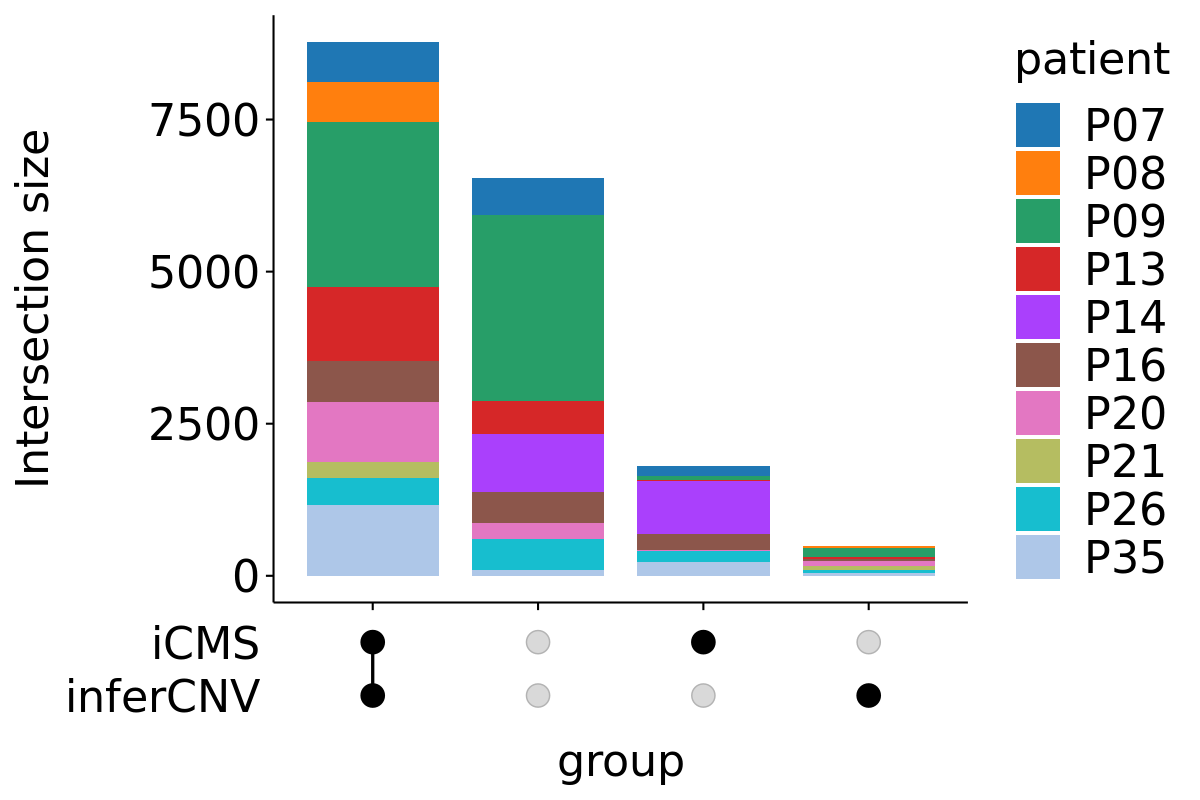

In [87]:
%%R -i upset_df -w 1200 -h 800 -r 200


# iCMS and inferCNV
df = upset_df %>%
select(iCMS_call, inferCNV_call_normal, patient) %>%
mutate(iCMS = ifelse(iCMS_call != 'normal', TRUE, FALSE),
       inferCNV = ifelse(inferCNV_call_normal == 'CNA', TRUE, FALSE)) 

p = upset(df, c('iCMS', 'inferCNV'), 
      #name = 'tumour calls by iCMS and inferCNV', 
      set_sizes = FALSE, height_ratio = 1/5,
      stripes = upset_stripes(
          colors = 'white'
          ),
      base_annotations = list('Intersection size' = intersection_size(
                                                      counts = FALSE, 
          mapping = aes(fill = patient), width = 0.8) +
                              scale_fill_manual(values = c('#1f77b4', '#ff7f0e', '#279e68', '#d62728', 
                                                            '#aa40fc', '#8c564b',
                                                            '#e377c2', '#b5bd61', '#17becf', '#aec7e8')) +
                              theme(panel.grid = element_blank(),
                                    axis.ticks = element_line('black'),
                                    axis.line = element_line()) + 
                              plot_theme_font_size(16)
                             )) + 
theme(panel.grid = element_blank())+
plot_theme_font_size(16) 

print(p)

#ggsave(file="iCMS_inferCNV_upset_by_pt.svg", width = 10, height = 10, units = "cm", dpi = 300)

# dont use theme_void(), there is something hidden in their code that will show some random texts

In [ ]:
%%R -i upset_df -w 800 -h 700 -r 200


df = upset_df %>%
select(scitcem_call, numbat, MS_status) %>%
mutate(Scitcem = ifelse(scitcem_call == 'tumour\n(tumour sample)', TRUE, FALSE),
       Numbat = ifelse(numbat == 'tumour\n(tumour sample)', TRUE, FALSE)) 

p = upset(df, rev(c('Scitcem', 'Numbat')), 
      #name = 'tumour calls by Scitcem and Numbat', 
      set_sizes = FALSE, height_ratio = 1/5,sort_sets=FALSE,
      stripes = upset_stripes(
          colors = 'white'
          ),
      base_annotations = list('Intersection size' = intersection_size(
                                                      counts = FALSE, mapping = aes(fill = MS_status), width = 0.8) +
                              scale_fill_manual(values = c('#D45B6E', '#EAA945'), name = 'Subtype') +
                              theme(panel.grid = element_blank(),
                                    axis.ticks = element_line('black'),
                                    axis.line = element_line()) + 
                              plot_theme_font_size(15)
                             )) + 
theme(panel.grid = element_blank())+
plot_theme_font_size(15)

print(p)

ggsave(file="Numbat_Scitcem_upset_by_MS.svg", width = 10, height = 10, units = "cm", dpi = 300)

# dont use theme_void(), there is something hidden in their code that will show some random texts

In [ ]:
%%R -i upset_df -w 1200 -h 800 -r 200


df = upset_df %>%
select(scitcem_call, numbat, inferCNV_result, iCMS_scANVI, patient) %>%
mutate(iCMS = ifelse(iCMS_scANVI != 'normal\n(tumour sample)', TRUE, FALSE),
       inferCNV = ifelse(inferCNV_result == 'CNA\n(tumour sample)', TRUE, FALSE),
       Scitcem = ifelse(scitcem_call == 'tumour\n(tumour sample)', TRUE, FALSE),
       Numbat = ifelse(numbat == 'tumour\n(tumour sample)', TRUE, FALSE)) 


p = upset(df, c('Numbat', 'Scitcem', 'inferCNV', 'iCMS'), 
      #name = 'tumour calls by Scitcem and Numbat', 
      set_sizes = FALSE, height_ratio = 1/3.5, sort_sets=FALSE,
      stripes = upset_stripes(
          colors = 'white'
          ),
      base_annotations = list('Intersection size' = intersection_size(
                                                    counts = FALSE, 
                                                    mapping = aes(fill = patient), width = 0.8) +
                               scale_fill_manual(values = c('#1f77b4', '#ff7f0e', '#279e68', '#d62728', 
                                                            '#aa40fc', '#8c564b',
                                                            '#e377c2', '#b5bd61', '#17becf', '#aec7e8')) +
                              theme(panel.grid = element_blank(),
                                    axis.ticks = element_line('black'),
                                    axis.line = element_line()) + 
                              plot_theme_font_size(15)
                             )) + 
theme(panel.grid = element_blank())+
plot_theme_font_size(15)

print(p)

ggsave(file="All_method_upset_by_pt.svg", width = 14, height = 10, units = "cm", dpi = 300)

# dont use theme_void(), there is something hidden in their code that will show some random texts

In [ ]:
%%R -i upset_df -w 1200 -h 800 -r 200


df = upset_df %>%
select(scitcem_call, numbat, inferCNV_result, iCMS_scANVI, MS_status) %>%
mutate(iCMS = ifelse(iCMS_scANVI != 'normal\n(tumour sample)', TRUE, FALSE),
       inferCNV = ifelse(inferCNV_result == 'CNA\n(tumour sample)', TRUE, FALSE),
       Scitcem = ifelse(scitcem_call == 'tumour\n(tumour sample)', TRUE, FALSE),
       Numbat = ifelse(numbat == 'tumour\n(tumour sample)', TRUE, FALSE)) 


p = upset(df, c('Numbat', 'Scitcem', 'inferCNV', 'iCMS'), 
      #name = 'tumour calls by Scitcem and Numbat', 
      set_sizes = FALSE, height_ratio = 1/3.5, sort_sets=FALSE,
      stripes = upset_stripes(
          colors = 'white'
          ),
      base_annotations = list('Intersection size' = intersection_size(
                                                    counts = FALSE, 
                                                    mapping = aes(fill = MS_status), width = 0.8) +
                               scale_fill_manual(values = c('#D45B6E', '#EAA945'), name = 'Subtype') +
                              theme(panel.grid = element_blank(),
                                    axis.ticks = element_line('black'),
                                    axis.line = element_line()) + 
                              plot_theme_font_size(15)
                             )) + 
theme(panel.grid = element_blank())+
plot_theme_font_size(15)

print(p)

ggsave(file="All_method_upset_by_MS.svg", width = 14, height = 10, units = "cm", dpi = 300)

# dont use theme_void(), there is something hidden in their code that will show some random texts

In [ ]:
cell_identity_list = adata_epi.obs[[
    'cell_identity', 'sample_cap', 'sample_origin','patient','Uhlitz_scANVI', 'Uhlitz_scANVI_noTC']]

In [ ]:
# number of epithelial cells per sample
cell_identity_list['sample_cap'].value_counts().sort_index()

In [ ]:
%%R -i cell_identity_list  -w 600 -h 500 -r 200

# Fig 3d
# bar plot of resolved cell identities in each tumour samples (both agree + more in Methods)


df = cell_identity_list %>% 
filter(sample_origin == 'tumour\nsample') %>%
group_by(sample_cap, cell_identity) %>%
mutate(sum=n()) %>%
group_by(sample_cap) %>%
mutate(sum_sample = n()) %>%
distinct(sample_cap, cell_identity, sum, sum_sample) %>%
arrange(sample_cap)

CI_order = rev(c('genomically_normal', 'no confident assignment', 'genomically_tumour'))

df$cell_identity = factor(df$cell_identity, levels = CI_order)

p = df %>%
ggplot(aes(x = sum, y = sample_cap, fill = cell_identity)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = rev(c('#1f77b4',
                            '#9b1ee3',
                            '#ff7f0e')),
                   name = 'Cell identity call\n(tumour samples)',
                   labels = rev(c('Genomically\nnormal',
                             'No confident\nassignment',
                              'Genomically\ntumour'))) +
theme_void() +
theme(axis.title.y = element_text(angle = 90)) +
labs(x = 'Proportion', 
     y = 'Sample\n') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,
                 labels = paste0(rev(unique(df$sample_cap)), ' (', rev(unique(df$sum_sample)), ')')) +
plot_theme_font_size(8) 

print(p)

ggsave(file="cell_identity_bar.svg", width = 7, height = 5, units = "cm", dpi = 300)

In [ ]:
set_infercnv = set(adata_epi[(adata_epi.obs['inferCNV_result'] == 'CNA\n(tumour sample)') & 
                                     (adata_epi.obs['sample_origin'] == 'tumour\nsample')].obs.index)
print(len(set_infercnv))

set_scitcem = set(adata_epi[(adata_epi.obs['scitcem_call'] == 'tumour\n(tumour sample)') & 
                                     (adata_epi.obs['sample_origin'] == 'tumour\nsample')].obs.index)
print(len(set_scitcem))

set_numbat = set(adata_epi[(adata_epi.obs['numbat'] == 'tumour\n(tumour sample)')& 
                                     (adata_epi.obs['sample_origin'] == 'tumour\nsample')].obs.index)
print(len(set_numbat))

set_icms_scANVI = set(adata_epi[(adata_epi.obs['iCMS_scANVI'] != 'normal\n(tumour sample)')& 
                                     (adata_epi.obs['sample_origin'] == 'tumour\nsample')].obs.index)
print(len(set_icms_scANVI))

In [ ]:
labels = venn.get_labels([set_icms_scANVI, set_scitcem, set_numbat, set_infercnv], fill = ['number'])
fig, ax = venn.venn4(labels, names = ['iCMS' ,'Scitcem', 'Numbat', 'inferCNV'])
#fig.suptitle('agreement on tumour cells (tumour sample only)', fontsize=24)
#ax.legend(bbox_to_anchor=(1.04, 1))
#ax.legend(frameon = False)
plt.legend([arr1a, arr2, arr3], ['u','v','u+v'])


In [ ]:
%%R -i upset_df -w 1600 -h 1200 -r 200

method_colors = c('#f57379','#f5d107', '#228b22', '#47a2ed')

df = upset_df %>%
select(scitcem_call, numbat, inferCNV_result, iCMS_scANVI,MS_status) %>%
mutate(iCMS = ifelse(iCMS_scANVI != 'normal\n(tumour sample)', TRUE, FALSE),
       inferCNV = ifelse(inferCNV_result == 'CNA\n(tumour sample)', TRUE, FALSE),
       Scitcem = ifelse(scitcem_call == 'tumour\n(tumour sample)', TRUE, FALSE),
       Numbat = ifelse(numbat == 'tumour\n(tumour sample)', TRUE, FALSE)) 


p=ggvenn(df, stroke_size = 0.2, set_name_size = 6, show_percentage = FALSE,
       fill_alpha = 0.5,
       set_name_color = method_colors,
       fill_color = method_colors) +
plot_theme_font_size(20)+
theme(axis.text = element_blank(),
     axis.title = element_blank())

print(p)

ggsave(file="venn.svg", width = 20, height = 20, units = "cm", dpi = 300)

In [ ]:
# Fig 3e
# UMAP of resolved cell identity

fig = sc.pl.umap(adata_epi, color=['cell_identity'], 
               ncols=1, legend_loc='right margin', size = 2,
              title = '', frameon = False, return_fig=True)

In [ ]:
# UMAP of resolved cell identity
fig = sc.pl.umap(adata_epi_noTC_cleanCI, color=['cell_identity'], 
               ncols=1, legend_loc='right margin', size = 2,
              title = '', frameon = False, return_fig=True)

In [ ]:
fig = sc.pl.umap(adata_epi_noTC_cleanCI, color=['PLA2G2A'], 
               ncols=1, legend_loc='right margin', size = 2,
               frameon = False, return_fig=True)

In [ ]:
fig = sc.pl.umap(adata_epi_noTC_cleanCI, color=['MUC1', 'MUC5B', 'OLFM4', 'WNT2'], 
               ncols=2, legend_loc='right margin', size = 2,
               frameon = False, return_fig=True)

In [ ]:
### Figure 4
- Tumour-like == genomicalyl tumour and remove TCs in normal sample and genomically normal
- no 'no confident assignment' cells

In [ ]:
adata_epi.obs['Uhlitz_scANVI_noTC'].cat.categories

In [ ]:
cell_identity_list_clean = adata_epi_noTC_cleanCI.obs[[
    'cell_identity', 'sample_cap', 'sample_origin','patient','Uhlitz_scANVI', 'Uhlitz_scANVI_noTC']]

In [ ]:
# Fig 4a
# UMAP with cell type annotation (epi cells)

fig = sc.pl.umap(adata_epi_noTC_cleanCI, color=['Uhlitz_scANVI_noTC'], 
               ncols=1, legend_loc='right margin', size = 2, title = 'Epithelial cell type',
               frameon = False, return_fig=True)

In [ ]:
%%R -i cell_identity_list_clean -w 700 -h 500 -r 200

# bar plot of resolved cell identities in each tumour samples (both agree + more in Methods)
# clean identity

df = cell_identity_list_clean %>% 
filter(sample_origin == 'tumour\nsample') %>%
group_by(sample_cap, cell_identity) %>%
mutate(sum=n()) %>%
group_by(sample_cap) %>%
mutate(sum_sample = n()) %>%
distinct(sample_cap, cell_identity, sum, sum_sample) %>%
arrange(sample_cap)

CI_order = c('genomically_normal', 'genomically_tumour')
df$cell_identity = factor(df$cell_identity, levels = CI_order)

p = df %>%
ggplot(aes(x = sum, y = sample_cap, fill = cell_identity)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = c('#1f77b4',
                            '#ff7f0e'),
                   name = 'Cell identity call\n(tumour samples)',
                   labels = c('genomically\nnormal',
                              'genomically\ntumour')) +
theme_void() +
theme(axis.title.y = element_text(angle = 90)) +
labs(x = 'Proportion', 
     y = 'Sample\n') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,labels = paste0(rev(unique(df$sample_cap)), ' (', rev(unique(df$sum_sample)), ')')) +
plot_theme_font_size(8) 

print(p)

ggsave(file="cell_identity_solved_by_sample_bar.svg", width = 7, height = 5, units = "cm", dpi = 300)

In [ ]:
%%R -i cell_identity_list_clean,Uhlitz_scANVI_noTC_color_list_after -w 1200 -h 500 -r 200

# cell type differences in genomically normal vs normal samples

df = cell_identity_list_clean %>%
filter(cell_identity %in% c('genomically_normal', 'normal_sample')) %>%
group_by(sample_cap, cell_identity, Uhlitz_scANVI_noTC) %>%
mutate(sum=n()) %>%
group_by(sample_cap) %>%
mutate(sum_sample = n()) %>%
distinct() %>%
arrange(desc(sample_cap))

df$Uhlitz_scANVI_noTC = factor(df$Uhlitz_scANVI_noTC, rev(levels(df$Uhlitz_scANVI_noTC)))


p = df %>%
ggplot(aes(x = sum, y = patient, fill = Uhlitz_scANVI_noTC)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = rev(Uhlitz_scANVI_noTC_color_list_after),
                 name = 'Epithelial cell type')+
theme_void() + 
theme(axis.title.y = element_text(angle = 90)) +
labs(x = 'Proportion', 
     y = 'Patient\n') +
facet_grid(cols = vars(cell_identity)) +
scale_y_discrete(limits = rev) +
scale_x_continuous(n.breaks = 3) +
plot_theme_font_size(8) 

print(p)

ggsave(file="cell_type_GN_vs_NN_pt_bar.svg", width = 12, height = 5, units = "cm", dpi = 300)

In [ ]:
%%R -i cell_identity_list_clean,Uhlitz_scANVI_noTC_color_list_after -w 1200 -h 500 -r 200

# Fig 4b
# cell type differences in genomically normal vs normal samples
suppressMessages(library(tidyverse))



df = cell_identity_list_clean %>%
filter(cell_identity %in% c('genomically_normal', 'normal_sample')) %>%
group_by(cell_identity, Uhlitz_scANVI_noTC) %>%
mutate(sum=n()) %>%
distinct(cell_identity, Uhlitz_scANVI_noTC, sum) 


df$Uhlitz_scANVI_noTC = factor(df$Uhlitz_scANVI_noTC, rev(levels(df$Uhlitz_scANVI_noTC)))

p = df %>% 
ggplot(aes(x = sum, y = cell_identity, fill = Uhlitz_scANVI_noTC)) +
geom_col(width = 0.8, position = 'fill') +
theme_void() + 
theme(axis.title.y = element_text(angle = 90)) +
scale_fill_manual(values = rev(Uhlitz_scANVI_noTC_color_list_after),name = 'Epithelial cell type') +
labs(x = '\nProportion\n', 
     y = 'Cell identity\n') +
guides(fill=guide_legend(ncol=2)) +
scale_x_continuous(n.breaks = 3) +
plot_theme_font_size(8) 

print(p)

ggsave(file="GN_NN_cell_type_bar.svg", width = 15, height = 4, units = "cm", dpi = 300)

In [ ]:
%%R -i cell_identity_list -w 1800 -h 1200 -r 200

suppressMessages(library(tidyverse))
suppressMessages(library('cowplot'))

plot_theme =  theme(title = element_text(size = 12),
                   axis.title = element_text(size = 12),
                   axis.text = element_text(size = 10),
                   legend.title =  element_text(size = 8),
                   text = element_text(size = 8),
                   plot.margin = margin(0,0,0,0,"cm"),
                   strip.text.x = element_text(size = 12)) 

table(cell_identity_list[c('cell_identity', 'Uhlitz_scANVI')]) %>%
as.data.frame() %>%
group_by(Uhlitz_scANVI) %>%
mutate(Percentage = round(Freq/sum(Freq)*100,0),Sum = sum(Freq)) %>% 
group_by(cell_identity) %>% mutate(Percentage_sample = round(Freq/sum(Freq)*100,0),Sum_sample = sum(Freq)) %>%
ggplot(aes(x = Uhlitz_scANVI, y = cell_identity)) + 
geom_tile(aes(fill = Percentage_sample), color = 'black') +
geom_text(aes(label = paste0(Freq, '\n', 
                             Percentage, '%\n',
                             Percentage_sample, '%'))) +
scale_fill_gradient(low = "grey95", high = "red", name = '% per cell identity') +
plot_theme + 
#coord_equal() +
theme(plot.title = element_text(hjust = 0.5),
      rect = element_blank(),
      axis.ticks = element_blank(),
      axis.text.x = element_text(angle = 90)) +
#guides(fill = guide_legend(title = "Count")) +
labs(title = '\nNumber of cell in each group\n',
     x = 'Cell type (including TCs)',
     y = 'Cell identity\n')

In [ ]:
%%R -i cell_identity_list,cell_type_list -w 1400 -h 800 -r 200

# Fig 4c
# Statistical testing of cell type differences in genomically normal vs normal samples

df = cell_identity_list %>%
filter(cell_identity %in% c('genomically_normal', 'normal_sample')) %>%
filter(!patient %in% c('P08', 'P21', 'P26', 'P35') ) 

df$cell_identity = factor(df$cell_identity, levels = c('normal_sample', 'genomically_normal'))

summary_model = list()
summary_p = list()

for(i in cell_type_list){
    glmer_model = glmer(Uhlitz_scANVI == i ~ cell_identity + (1|patient), 
             family="binomial", data = df)
    summary_model[[i]] = summary(glmer_model)
    summary_p[[i]] = data.frame('Uhlitz_scANVI' = i, 
           'p' = summary(glmer_model)$coefficients['cell_identitygenomically_normal','Pr(>|z|)'])
}
# boundary (singular) fit: see help('isSingular')
# means random effects are very small

glmer_p_stats = bind_rows(summary_p) %>% 
filter(!Uhlitz_scANVI %in% c('TC1','TC2','TC3','TC4')) %>%
mutate(loc = seq(1,7,1), p = signif(p,2)) %>%
mutate(star = case_when(p < 0.05 ~ '< 0.05'))

print(glmer_p_stats)

table(cell_identity_list[c('Uhlitz_scANVI', 'patient', 'cell_identity')]) %>%
as.data.frame() %>%
filter(cell_identity %in% c('genomically_normal', 'normal_sample')) %>%
filter(!patient %in% c('P08', 'P21', 'P26', 'P35') ) %>%
filter(!Uhlitz_scANVI %in% c('TC1','TC2','TC3','TC4')) %>%
group_by(cell_identity, patient) %>% 
mutate(frac_sample = Freq/sum(Freq)) %>% 
ggplot(aes(x = Uhlitz_scANVI, y = frac_sample)) +
geom_boxplot(outlier.color = 'white', aes(color = cell_identity)) +
geom_point(position=position_jitterdodge(), aes(color = cell_identity), size = 1)+
theme_bw() + 
theme(axis.text.x = element_text(angle = 90),
      panel.grid = element_blank()) +
labs(x = 'Epithelial cell types',
     y = 'Fraction per sample\n') +
scale_color_manual(values = c('#1f77b4', '#808080'), name = 'Cell identity') +
geom_bracket(aes(xmin = loc-0.25, xmax = loc+0.25, label = p), data = glmer_p_stats, 
             y.position = c(0.45, 0.4, 0.2, 0.4, 0.45, 0.55, 0.25), size = 0.2, label.size = 3) +
ylim(0,0.65) +
plot_theme_font_size(8) 

ggsave(file="GN_NN_cell_type_bar.svg", width = 15, height = 4, units = "cm", dpi = 300)

In [ ]:
# Fig 4d
# diffusion map

fig = sc.pl.diffmap(adata_epi_noTC_cleanCI, color=['Uhlitz_scANVI_noTC'], 
               ncols=1, legend_loc='right margin', size = 2, title = 'Diffusion map dim 1 and 2',
               frameon = False, return_fig=True)


In [ ]:
adata_epi_noTC_cleanCI.obs[['DC1', 'DC2', 'DC3', 'DC4']]= adata_epi_noTC_cleanCI.obsm['X_diffmap'][:,1:5].copy()

In [ ]:
order_start_with_tumour_noTC = [
 'Tumour-like',
 'Stem',
 'Stem/TA',
 'Immature Goblet',
 'Goblet',
 'Enterocyte progenitor',
 'Enterocytes',
 'Tuft']

In [ ]:
order_start_with_stem_noTC = ['Stem',
 'Stem/TA',
 'Immature Goblet',
 'Goblet',
 'Enterocyte progenitor',
 'Enterocytes',
 'Tuft']

In [ ]:
with plt.rc_context({'ytick.major.size':18, 'axes.titlesize':18}):
    plt.figure(figsize = (8/2.54,5/2.54))

    g = sns.JointGrid(data = adata_epi_noTC_cleanCI.obs, x = 'DC1', y = 'DC2', hue = 'Uhlitz_scANVI_noTC',
                      hue_order=order_start_with_tumour_noTC,
                      palette=[sample_color_map[key] for key in order_start_with_tumour_noTC],
                      height = 9, ratio = 3)
    g.plot_joint(sns.scatterplot, s = 2, edgecolor = None)
    g.plot_marginals(sns.histplot, kde = False, binwidth=0.001, edgecolor = 'black', linewidth = 0.3, alpha =1)

    sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.5, 1), title = 'Epithelial cell type', 
                    frameon=False, title_fontsize = 14)

    #g.ax_joint.legend_.remove()
;

In [ ]:
adata_epi_noTC_cleanCI[adata_epi_noTC_cleanCI.obs['cell_identity'] == 'genomically_normal'].obs['DC2'].min()

In [ ]:
adata_epi_noTC_cleanCI[adata_epi_noTC_cleanCI.obs['cell_identity'] == 'genomically_normal'].obs['DC2'].max()

In [ ]:
adata_epi_noTC_cleanCI[(adata_epi_noTC_cleanCI.obs['cell_identity'] == 'normal_sample') & 
         (adata_epi_noTC_cleanCI.obs['DC2'] < -0.006)].obs[['sample', 'Uhlitz_scANVI_noTC']]
#use in CellChat obj

In [ ]:
np.arange(-0.007,0.012,0.001)

In [ ]:
with plt.rc_context({'ytick.major.size':16, 'axes.titlesize':18}):
    plt.figure(figsize = (8,5))
    ax = sns.histplot(adata_epi_noTC_cleanCI[adata_epi_noTC_cleanCI.obs['cell_identity'] == 'genomically_normal'].obs, 
                      x = 'DC2', hue = 'Uhlitz_scANVI_noTC', binwidth=0.001, stat = 'count',
                      legend='right', multiple="stack", 
                      palette=[sample_color_map[key] for key in order_start_with_stem_noTC],
                      hue_order=order_start_with_stem_noTC, edgecolor = 'black')
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.4, 1.0), title='Cell type', frameon=False)
    plt.title('Diffusion map dim 2 distribution of\ngenomically normal cells\n')
    plt.ylabel('Normalised count')

# Dig out how many cells per bin
# can only use with stack due to normalised count if use multiple = fill
ary = []

print(len(ax.containers))

for i in ax.containers:
    ary = np.append(ary,i.datavalues)


number_cell_per_bin = [str(int(sum(x))) for x in zip(*ary.reshape(7,18))]
print(number_cell_per_bin)

In [ ]:
# Fig 4e
# DC2 of genomically normal and normal cells
with plt.rc_context({'ytick.major.size':16, 'axes.titlesize':18}):
    plt.figure(figsize = (8,5))
    ax = sns.histplot(adata_epi_noTC_cleanCI[adata_epi_noTC_cleanCI.obs['cell_identity'] == 'genomically_normal'].obs, 
                      x = 'DC2', hue = 'Uhlitz_scANVI_noTC', binwidth=0.001, stat = 'count',
                      legend='right', multiple="fill", 
                      palette=[sample_color_map[key] for key in order_start_with_stem_noTC],
                      hue_order=order_start_with_stem_noTC, edgecolor = 'black')
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.45, 1.0), title='Epithelial cell type', frameon=False,
                   title_fontsize = 15)
    #plt.title('Diffusion map dim 2 distribution of\ngenomically normal cells\n')
    plt.ylabel('Normalised count', size = 15)
    plt.xlabel('Diffusion map dimension 2', size = 15)
    
    #x = np.arange(-0.0061,0.018,0.00101)
    #y = [1.05]*18
    #for i, text in enumerate(number_cell_per_bin):
    #    ax.text(x[i], y[i], text, fontsize=10, ha = 'right',va = 'center')
    

In [ ]:
adata_epi_noTC_cleanCI[adata_epi_noTC_cleanCI.obs['sample_origin'] == '\nnormal\nsample\n'].obs['DC2'].min()

In [ ]:
adata_epi_noTC_cleanCI[adata_epi_noTC_cleanCI.obs['sample_origin'] == '\nnormal\nsample\n'].obs['DC2'].max()

In [ ]:
with plt.rc_context({'ytick.major.size':16, 'axes.titlesize':18}):
    plt.figure(figsize = (8,5))
    ax = sns.histplot(adata_epi_noTC_cleanCI[adata_epi_noTC_cleanCI.obs['sample_origin'] == '\nnormal\nsample\n'].obs, 
                      x = 'DC2', hue = 'Uhlitz_scANVI_noTC', binwidth=0.001, stat = 'count',
                      legend='right', multiple="stack", 
                      palette=[sample_color_map[key] for key in order_start_with_stem_noTC],
                      hue_order=order_start_with_stem_noTC, edgecolor = 'black')
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.45, 1.0), title='Cell type', frameon=False)
    plt.title('Diffusion map dim 2 distribution of\ncells from normal samples\n')
    plt.ylabel('Normalised count')
    
ary = []

print(len(ax.containers))
for i in ax.containers:
    ary = np.append(ary,i.datavalues)
    
number_cell_per_bin = [str(int(sum(x))) for x in zip(*ary.reshape(7,19))] 
print(number_cell_per_bin)

In [ ]:
# Figure 4e
with plt.rc_context({'ytick.major.size':16, 'axes.titlesize':18}):
    plt.figure(figsize = (8,5))
    ax = sns.histplot(adata_epi_noTC_cleanCI[adata_epi_noTC_cleanCI.obs['sample_origin'] == '\nnormal\nsample\n'].obs, 
                      x = 'DC2', hue = 'Uhlitz_scANVI_noTC', binwidth=0.001, stat = 'count',
                      legend='right', multiple="fill", 
                      palette=[sample_color_map[key] for key in order_start_with_stem_noTC],
                      hue_order=order_start_with_stem_noTC, edgecolor = 'black')
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.45, 1.0), title='Epithelial cell type', frameon=False,
                   title_fontsize = 15)
    #plt.title('Diffusion map dim 2 distribution of\ncells from normal samples\n')
    plt.ylabel('Normalised count', size = 15)
    plt.xlabel('Diffusion map dimension 2', size = 15)

    
    #x = np.arange(-0.0068,0.013,0.001)
    #y = [1.04]*19
    #for i, text in enumerate(number_cell_per_bin):
    #    ax.text(x[i], y[i], text, fontsize=8, ha = 'center',va = 'center')
    

In [ ]:
# Figure 
fig = sc.pl.umap(adata_epi_noTC_cleanCI, color=['ct_pseudotime'], 
               ncols=1, legend_loc='right margin', size = 2, title = '',
               frameon = False, return_fig=True, color_map='viridis_r')


In [ ]:
fig = sc.pl.diffmap(adata_epi_noTC_cleanCI, color=['ct_pseudotime'], 
               ncols=1, legend_loc='right margin', size = 2, title = '',
               frameon = False, return_fig=True, color_map='viridis_r')


In [ ]:
# cytoTRACE
with plt.style.context('./plt_style'):
    g=sns.FacetGrid(adata_epi_noTC_cleanCI.obs, 
                    col = 'Uhlitz_scANVI_noTC', hue = 'cell_identity', 
                    height = 4, aspect = 5/9, despine = False, sharey = True, 
                    #col_order = new_order_noTC, 
                    palette = ['#ff7f0e',
                               '#1f77b4','#808080']) # a darker grey for normal

    g.map_dataframe(sns.violinplot, x = 'cell_identity', y = 'ct_pseudotime', width = 0.7)
    g.figure.subplots_adjust(wspace=0)
    
    g.set_xticklabels(rotation = 90)
    g.set_titles('{col_name}\n')
    g.set(ylim=(0, 1))
    g.set_xlabels('')
    g.set_ylabels('Cytoscape pseudotime\n', loc = 'top')
    
    g.fig.text(x = 0.5, y = -1, horizontalalignment = 'center', s = 'Cell identity', size = 24)
    
    axes = g.axes.flatten()
    axes[6].set_title('Enterocyte\nprogenitor\n')
    axes[7].set_title('Enterocyte\n')
    axes[4].set_title('Immature\ngoblet\n')
;    

In [ ]:
#Fig4f
#cytoTRACE without genomically tumour
with plt.style.context('./plt_style'):
    g=sns.FacetGrid(adata_epi_noTC_cleanCI[adata_epi_noTC_cleanCI.obs['cell_identity'] != 'genomically_tumour'].obs, 
                    col = 'Uhlitz_scANVI_noTC', hue = 'cell_identity', 
                    height = 4, aspect = 5/9, despine = False, sharey = True, 
                    #col_order = new_order_noTC, 
                    palette = [#'#ff7f0e',
                               '#1f77b4','#808080']) # a darker grey for normal

    g.map_dataframe(sns.violinplot, x = 'cell_identity', y = 'ct_pseudotime', width = 0.7)
    g.figure.subplots_adjust(wspace=0)
    
    g.set_xticklabels(rotation = 90)
    g.set_titles('{col_name}\n')
    g.set(ylim=(0, 1))
    g.set_xlabels('')
    g.set_ylabels('Cytoscape pseudotime\n', loc = 'top')
    
    g.fig.text(x = 0.5, y = -1, horizontalalignment = 'center', s = 'Cell identity', size = 24)
    
    axes = g.axes.flatten()
    axes[5].set_title('Enterocyte\nprogenitor\n')
    axes[6].set_title('Enterocyte\n')
    axes[3].set_title('Immature\ngoblet\n')
;    

In [ ]:
cyto_list = adata_epi_noTC_cleanCI.obs[['cell_identity', 'ct_pseudotime', 'Uhlitz_scANVI_noTC', 'louvain']]

In [ ]:
%%R -i cyto_list,Uhlitz_scANVI_noTC_color_list -w 3000 -h 900 -r 200

p = cyto_list %>% 
mutate(Uhlitz_scANVI_noTC = dplyr::recode(Uhlitz_scANVI_noTC, 'Tumour-like' =  'Tumour- like')) %>%
ggplot(aes(x = cell_identity, y = ct_pseudotime)) +
geom_violin(aes(fill = Uhlitz_scANVI_noTC), width = 0.8) +
geom_boxplot(width = 0.2) +
#geom_jitter(shape = 16, position = position_jitter(0.3), size = 0.01) +
theme_void()+
plot_theme_font_size(15) +
theme(axis.title.y = element_text(angle = 90),
      axis.text.x = element_text(angle = 90),
      axis.ticks.y = element_line('black', linewidth = 1),
      axis.ticks.length=unit(0.1, "cm"),
      axis.text.y = element_text(margin = margin(t = 0, r = 7, b = 0, l = 0)),
      axis.line = element_line()) +
scale_fill_manual(values = Uhlitz_scANVI_noTC_color_list, name = 'Epithelial cell type') +
facet_grid(cols = vars(Uhlitz_scANVI_noTC), space = 'free', scale = 'free', 
          labeller = label_wrap_gen(width = 10)) + 
labs(x = 'Cell identity',
     y = 'Cytotrace pseudotime\n') +
scale_y_continuous(n.breaks = 3)

print(p)

ggsave(file="ct_cell_type_violin.svg", width = 38, height = 12, units = "cm", dpi = 300)


In [ ]:
%%R -i cyto_list,order_start_with_stem_noTC
 
for(i in order_start_with_stem_noTC){
    df = cyto_list %>% 
    filter(Uhlitz_scANVI_noTC == i) %>%
    filter(cell_identity != 'genomically_tumour')
    
    print(i)
    print(pairwise.t.test(df$ct_pseudotime, df$cell_identity, p.adj='bonferroni'))
   
}


In [ ]:
%%R -i cyto_list,order_start_with_stem_noTC

 
for(i in order_start_with_stem_noTC){
    df = cyto_list %>%
    filter(Uhlitz_scANVI_noTC == i) %>%
    filter(cell_identity != 'genomically_tumour')
    
    print(i)
    
    print(t.test(ct_pseudotime ~ cell_identity, alternative = "two.sided", 
       data = df,
       conf.level = .95, 
       paired = FALSE))
}

In [ ]:
%%R -i cyto_list

# contrast in linear model
library('emmeans')

cyto_lm  = cyto_list %>% filter(cell_identity != 'genomically_tumour') %>%
lm(ct_pseudotime ~ Uhlitz_scANVI_noTC + cell_identity, data = .)
print(summary(cyto_lm))

pairs(emmeans(cyto_lm, ~cell_identity))


In [ ]:
%%R -i cyto_list


for(i in order_start_with_stem_noTC){
    df = cyto_list %>%
    filter(Uhlitz_scANVI_noTC == i) %>%
    filter(cell_identity != 'genomically_tumour')
    
    print(i)
    
    df$cell_identity = relevel(df$cell_identity, ref = 'normal_sample')
    lm_Uhlitz = lm(ct_pseudotime ~ cell_identity, data = df)
    print(summary(lm_Uhlitz))
    
    print(pairs(emmeans(lm_Uhlitz, ~ cell_identity), reverse = TRUE))
}


In [ ]:
%%R -i cyto_list

# two sample wilcox
library('rstatix')

wilcox_test(data = cyto_list, ct_pseudotime ~ cell_identity, ref.group = 'genomically_normal') %>% as.data.frame()

In [ ]:
%%R -i cyto_list

#two sample wilcox

for(i in order_start_with_stem_noTC){
    df = cyto_list %>%
    filter(Uhlitz_scANVI_noTC == i) %>%
    filter(cell_identity != 'genomically_tumour')
    
    print(i)
    
    print(wilcox.test(data = df, ct_pseudotime ~ cell_identity, paired = FALSE, alternative = "two.sided"))
}


In [ ]:
%%R -i cyto_list

# two sample wilcox with multiple testing correction

for(i in order_start_with_stem_noTC){
    
    df = cyto_list %>%
    filter(Uhlitz_scANVI_noTC == i) %>%
    filter(cell_identity != 'genomically_tumour')
    
    print(i)
    
    print(pairwise.wilcox.test(df$ct_pseudotime, df$cell_identity, paired = FALSE, p.adjust.method = "bonf"))
}


In [ ]:
# cluster pseudotime
with plt.style.context('./plt_style'):
    g=sns.FacetGrid(adata_epi_noTC_cleanCI.obs, 
                    col = 'louvain', hue = 'sample_origin', 
                    height = 4, aspect = 3/9, despine = False, sharey = True, 
                    #col_order = new_order_noTC, 
                    palette = ['#ff7f0e',
                               #'#1f77b4',
                               '#808080']) # a darker grey for normal

    g.map_dataframe(sns.violinplot, x = 'sample_origin', y = 'ct_pseudotime', width = 0.7)
    g.figure.subplots_adjust(wspace=0)
    
    g.set_xticklabels(rotation = 90)
    g.set_titles('{col_name}\n')
    g.set(ylim=(0, 1))
    g.set_xlabels('')
    g.set_ylabels('Cytoscape pseudotime\n', loc = 'top')
    
    g.fig.text(x = 0.5, y = -1, horizontalalignment = 'center', s = 'sample_origin', size = 24)
    
    axes = g.axes.flatten()
    #axes[5].set_title('Enterocyte\nprogenitor\n')
    #axes[6].set_title('Enterocyte\n')
    #axes[3].set_title('Immature\ngoblet\n')

In [ ]:
%%R -i cyto_list -w 2200 -h 900 -r 200

suppressMessages(library(tidyverse))

cyto_list %>% 
mutate(Uhlitz_scANVI_noTC = dplyr::recode(Uhlitz_scANVI_noTC, 'Tumour-like' =  'Tumour- like')) %>%
ggplot(aes(x = cell_identity, y = ct_pseudotime)) +
geom_violin(aes(fill = cell_identity)) +
#geom_boxplot(width = 0.2) +
#geom_jitter(shape = 16, position = position_jitter(0.3), size = 0.01) +
theme_void()+
theme(axis.title.y = element_text(angle = 90),
      axis.text.x = element_text(angle = 90),
      strip.text.x = element_text(size = 10)) +
scale_fill_manual(values = c('#ff7f0e', 
                             '#1f77b4','#808080')) +
facet_grid(cols = vars(louvain), space = 'free', scale = 'free', 
          labeller = label_wrap_gen(width = 10)) + 
labs(x = 'Cell identity',
     y = 'Cytotrace pseudotime\n') +
plot_theme_font_size(15)


In [ ]:
%%R -i cyto_list,Uhlitz_scANVI_noTC_color_list -w 2000 -h 800 -r 200

cyto_list %>% 
filter(louvain %in% c('9')) %>%
mutate(Uhlitz_scANVI_noTC = dplyr::recode(Uhlitz_scANVI_noTC, 'Tumour-like' =  'Tumour- like')) %>%
ggplot(aes(x = cell_identity, y = ct_pseudotime)) +
geom_violin(aes(fill = Uhlitz_scANVI_noTC)) +
theme_void()+
plot_theme_font_size(15) +
theme(axis.title.y = element_text(angle = 90),
      axis.text.x = element_text(angle = 90),
      strip.text.x = element_text(size = 10),
      axis.line = element_line(),
      axis.ticks = element_line()) +
scale_fill_manual(values = c('#AA0000',
 '#00CCFF',
 '#0072b1', '#990099','#999900',
 '#336600')) +
facet_grid(cols = vars(Uhlitz_scANVI_noTC),
          labeller = label_wrap_gen(width = 10)) + 
labs(x = 'Cell identity',
     y = 'Cytotrace pseudotime\n') 


In [ ]:
%%R -i cyto_list,Uhlitz_scANVI_noTC_color_list -w 2000 -h 800 -r 200


cyto_list %>% 
filter(Uhlitz_scANVI_noTC == 'Stem') %>%
ggplot(aes(x = cell_identity, y = ct_pseudotime)) +
geom_violin(aes(fill = louvain)) +
theme_void()+
plot_theme_font_size(15) +
theme(axis.title.y = element_text(angle = 90),
      axis.text.x = element_text(angle = 90),
      strip.text.x = element_text(size = 10),
      axis.line = element_line(),
      axis.ticks = element_line(),
      panel.grid.major.y =  element_line(color = 'grey', size = 0.25)) +
facet_grid(cols = vars(louvain),
          labeller = label_wrap_gen(width = 10)) + 
labs(x = 'Cell identity',
     y = 'Cytotrace pseudotime\n') +
ylim(0,1)


In [ ]:
adata_epi_noTC_cleanCI[adata_epi_noTC_cleanCI.obs['Uhlitz_scANVI_noTC'] == 'Stem'].obs['louvain'].value_counts().sort_index()

In [ ]:
%%R -i cyto_list,Uhlitz_scANVI_noTC_color_list -w 3000 -h 1600 -r 200

# clusters that have some Stem and Stem/TA
suppressMessages(library(tidyverse))


cyto_list %>% 
mutate(Uhlitz_scANVI_noTC = dplyr::recode(Uhlitz_scANVI_noTC, 'Tumour-like' =  'Tumour- like')) %>%
ggplot(aes(x = cell_identity, y = ct_pseudotime)) +
geom_violin(aes(fill = Uhlitz_scANVI_noTC)) +
#geom_boxplot(width = 0.2) +
#geom_jitter(shape = 16, position = position_jitter(0.3), size = 0.01) +
theme_void()+
plot_theme_font_size(15) +
theme(axis.title.y = element_text(angle = 90),
      axis.text.x = element_text(angle = 90),
      strip.text = element_text(size = 10),
      axis.line = element_line(),
      axis.ticks = element_line(), 
      panel.border = element_rect(color = 'black', fill = NA, size = 0.5), 
      panel.grid.major.y = element_line(color = 'grey', size = 0.25)) +
scale_fill_manual(values = Uhlitz_scANVI_noTC_color_list) +
facet_grid(cols = vars(louvain), rows = vars(Uhlitz_scANVI_noTC),
          labeller = label_wrap_gen(width = 10)) + 
labs(x = '\nCell identity',
     y = 'Cytotrace pseudotime\n') 


In [ ]:
#### export table for Markus

In [ ]:
table_for_Markus = adata_epi.obs[['sample', 'sample_origin', 'filter_dp', 'iCMS_scANVI', 'inferCNV_result', 'scitcem_call', 
                                  'scitcem_p', 'numbat', 'p_cnv', 'cell_identity', 'Uhlitz_scANVI']]

In [ ]:
table_for_Markus['sample_origin'].cat.rename_categories({'\nnormal\nsample\n':'normal_sample', 
                                                     'tumour\nsample':'tumour_sample'}, inplace =True)

In [ ]:
table_for_Markus['iCMS_scANVI'].cat.rename_categories({'iCMS2\n(tumour sample)':'iCMS2 (tumour sample)', 
                                                      'iCMS3\n(tumour sample)':'iCMS3 (tumour sample)',
                                                       'normal\n(tumour sample)':'normal (tumour sample)'}, 
                                                      inplace =True)

In [ ]:
table_for_Markus['inferCNV_result'].cat.rename_categories({'CNA\n(tumour sample)':'CNA (tumour sample)', 
                                                        'CNN\n(tumour sample)':'CNN (tumour sample)'}, 
                                                          inplace =True)

In [ ]:
table_for_Markus['scitcem_call'].cat.rename_categories({'tumour\n(tumour sample)':'tumour (tumour sample)', 
                                                        'normal\n(tumour sample)':'normal (tumour sample)'}, 
                                                          inplace =True)

In [ ]:
table_for_Markus['numbat'].cat.rename_categories({'tumour\n(tumour sample)':'tumour (tumour sample)', 
                                                        'normal\n(tumour sample)':'normal (tumour sample)'}, 
                                                          inplace =True)

In [ ]:
table_for_Markus.columns

In [ ]:
table_for_Markus.rename(columns={'iCMS_scANVI':'iCMS',
                                 'inferCNV_result':'inferCNV',
                                 'scitcem_call': 'Scitcem',
                                 'scitcem_p':'Scitcem_p',
                                 'numbat': 'Numbat',
                                 'p_cnv': 'Numbat_p',
                                 'cell_identity': 'Numbat_Scitcem_Resolved',
                                 'filter_dp':'Total_SNV',
                                 'Uhlitz_scANVI' : 'Cell_type'}, inplace=True)

In [ ]:
table_for_Markus.to_csv(Path(new_data_folder)/'202311_four_tools_result_and_Numbat_Scitcem_resolved_cell_identity.csv')

In [ ]:
adata_all.obs = adata_all.obs.merge(adata_epi.obs['cell_identity'], left_index = True,
                    right_index = True, how='left').set_axis(adata_all.obs.index)

In [ ]:
adata_all.obs['cell_identity'] = adata_all.obs['cell_identity'].fillna('normal_sample')

In [ ]:
adata_all.obs['cell_identity'].value_counts(dropna=False)

In [ ]:
#another table
allcell_table_for_Markus = adata_all.obs[['sample', 'sample_origin', 'celltype_1a', 'cell_type_level2', 'cell_identity']]

In [ ]:
allcell_table_for_Markus.to_csv(Path(new_data_folder)/'202311_epi_imm_str_cell_type_and_cell_identity.csv')

In [ ]:
### Figure 5

In [ ]:
all_cell_list = adata_all_noTC_cleanCI.obs[['patient', 'sample_cap',
                                            'celltype_1a','cell_type_level2', 'sample_origin']]

In [ ]:
%%R -i cell_identity_list_clean,all_cell_list,removed_TC_id -w 1000 -h 500 -r 200

# Fig. 5a 
# proportion of each cell compartment (epi, imm, str) of each sample
suppressMessages(library(tidyverse))


df = all_cell_list %>%
merge(cell_identity_list_clean[c('cell_identity', 'Uhlitz_scANVI_noTC')], by = 0, all.x = TRUE) %>%
#filter(Row.names %notin% removed_TC_id) %>%
mutate(cell_type_merge = coalesce(cell_identity, celltype_1a)) %>%
group_by(sample_cap, cell_type_merge) %>%
mutate(sum=n()) %>%
group_by(sample_cap) %>%
mutate(sum_sample = n()) %>%
distinct(sample_cap,cell_type_merge, sum, sum_sample, patient, sample_origin)

df$cell_type_merge = factor(df$cell_type_merge, levels = c('imm', 'str', 'normal_sample',
                                                             'genomically_normal', 
                                                             'genomically_tumour'))

p = df %>%
ggplot(aes(x = sum, y = patient, fill = cell_type_merge)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = c('#ED5D47',
                            '#4EAC57',
                             '#144FAC',
                            '#1f77b4',
                            '#ff7f0e'),
                   name = 'Cell identity',
                   labels = c('Immune',
                             'Stromal', 
                              'Epithelial',
                             'Genomically\nnormal',
                             'Genomically\ntumour')) +
theme_void() + 
plot_theme_font_size(8) +
theme(axis.title.y = element_text(angle = 90),
      panel.spacing = unit(10, "pt")) +
labs(x = 'Proportion', 
     y = '') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,
                 labels = paste0(rev(unique(df$patient)))) +
facet_grid(cols = vars(sample_origin), 
           labeller = as_labeller(c('normal' = 'Normal\nsample', 'tumour' = 'Tumour\nsample')))
print(p)

ggsave(file="cell_identity_and_TME_normal_tumour_sample.svg", width = 8, height = 5, units = "cm", dpi = 300)


In [ ]:
# Figure 5b pathway activity


In [ ]:
# Figure 5 expressed receptors on epi > go to 20231122_ligand...notebook

In [ ]:
adata_all_noTC_cleanCI.obs['celltype_1a'].cat.categories

In [ ]:
adata_all_noTC_cleanCI[adata_all_noTC_cleanCI.obs['celltype_1a'] != 'epi'].obs['cell_type_level2'].cat.categories

In [ ]:
sample_color_map_for_all = sample_color_map.copy()

sample_color_map_for_all.update(dict(zip(adata_all_noTC_cleanCI[adata_all_noTC_cleanCI.obs['celltype_1a'] != 'epi'].obs['cell_type_level2'].cat.categories, 
         ['#7d8df0', '#335B8E', '#79c9c9', '#67C9FF',
          '#CE9486', '#8f7022', '#cf7708', '#B5B867',
          '#DEB058', '#899DA4','#1aa375', '#AA82A7', '#c44545'
         ])))

In [ ]:
sample_color_map_grey = dict(zip(adata_epi_noTC_cleanCI.obs['Uhlitz_scANVI_noTC'].cat.categories, 
                            ['#d3d3d3']*8))

In [ ]:
sample_color_map_grey.update(dict(zip(adata_all_noTC_cleanCI[adata_all_noTC_cleanCI.obs['celltype_1a'] != 'epi'].obs['cell_type_level2'].cat.categories, 
         ['#7d8df0', '#335B8E', '#79c9c9', '#67C9FF',
          '#CE9486', '#8f7022', '#cf7708', 
          '#B5B867',
          '#DEB058', '#899DA4','#1aa375', '#AA82A7', '#c44545'
         ])))

In [ ]:
sample_color_map_grey.update(dict(zip(['TC1', 'TC2', 'TC3', 'TC4'], ['#d3d3d3']*8)))

In [ ]:
fig = sc.pl.umap(adata_all_noTC_cleanCI[adata_all_noTC_cleanCI.obs['celltype_1a'] != 'epi'], 
                 color=['sample_origin'], 
               ncols=1, legend_loc='right margin', size = 1, title = '',
               frameon = False, return_fig=True, palette=['#808080','#ff7f0e'])


In [ ]:
fig = sc.pl.umap(adata_all_noTC_cleanCI, 
                 color=['cell_type_level2'], 
               ncols=1, legend_loc='right margin', size = 1, title = '',
               frameon = False, return_fig=True, palette=sample_color_map_grey)


In [ ]:
fig = sc.pl.umap(adata_all_noTC_cleanCI[adata_all_noTC_cleanCI.obs['celltype_1a'] != 'epi'], 
                 color=['cell_type_level2'], 
               ncols=1, legend_loc='right margin', size = 1, title = '',
               frameon = False, return_fig=True, palette=sample_color_map_for_all)


In [ ]:
fig = sc.pl.umap(adata_all_noTC_cleanCI[(adata_all_noTC_cleanCI.obs['celltype_1a'] != 'epi') & 
                        (adata_all_noTC_cleanCI.obs['sample_origin'] == 'tumour')], 
                 color=['cell_type_level2'], 
               ncols=1, legend_loc='right margin', size = 1, title = '',
               frameon = False, return_fig=True, palette=sample_color_map_for_all)


In [ ]:
# double check CAFs
# CRC CAFA: MMP2, DCN, COL1A2
# CRC CAFB: ACTA2, PDGFA, TAGLN

fig = sc.pl.umap(adata_all_noTC_cleanCI, 
                 color=['EPCAM', 'CALD1', 'SMTN', 'PTPRC', 'PECAM1'],  # negetive marker: CALD1 is pericyte
               ncols=3, legend_loc='right margin', size = 1, 
               frameon = False, return_fig=True, palette=sample_color_map_for_all)


In [ ]:
fig = sc.pl.umap(adata_all_noTC_cleanCI, 
                 color=['MMP2', 'DCN', 'COL1A2','ACTA2', 'PDGFA', 'TAGLN',
                      'FAP','MFAP5', 'COL11A1', 'TNC', 'PDPN', 'ITGA11', 'CSPG4', # also CAF
                      'PDGFRA', 'PDGFRB', 'VIM'], # Fibroblast],  # negetive marker: CALD1 is pericyte
               ncols=3, legend_loc='right margin', size = 1, 
               frameon = False, return_fig=True, palette=sample_color_map_for_all)


In [ ]:
### Other plots

In [ ]:
fig = sc.pl.umap(adata_all_noTC_cleanCI, 
                 color=['louvain'], 
               ncols=3, legend_loc='on data', size = 1, 
               frameon = False, return_fig=True)


In [ ]:
cluster_list = adata_epi_noTC_cleanCI.obs[['louvain', 'leiden', 'cell_identity', 
                                           'tumour_normal_normal', 'sample_origin',
                                           'Uhlitz_scANVI_noTC','iCMS_scANVI', 'inferCNV_result', 'sample_cap']]

In [ ]:
%%R

cluster_list %>%
filter(cell_identity == 'genomically_normal') %>%
group_by(sample_cap) %>%
mutate(n_sample = n()) %>%
group_by(sample_cap, louvain) %>%
mutate(n_louvain_per_sample = n(), frac_louvain = n_louvain_per_sample/n_sample) %>%
distinct(sample_cap, louvain, n_sample, n_louvain_per_sample, frac_louvain) %>%
select(sample_cap, louvain, n_sample, n_louvain_per_sample, frac_louvain) %>%
arrange(sample_cap, louvain) %>% 
filter(louvain == '9')

In [ ]:
%%R -i cluster_list -w 900 -h 900 -r 200

# proportion of each cell identity in each cluster

df = cluster_list %>%
group_by(louvain, cell_identity) %>%
mutate(sum=n()) %>%
group_by(louvain) %>%
mutate(sum_louvain = n()) %>%
distinct(louvain, cell_identity, sum, sum_louvain) %>%
arrange(louvain)


df$cell_identity = factor(df$cell_identity, levels = rev(c('normal_sample',
                                                       'genomically_normal',
                                                       'genomically_tumour')))

Tumour_island_color = rev(ifelse(seq(0,19,1) %in% c(4,5,12,13,15,16,19), '#ff7f0e', '#808080'))

p = df %>%
ggplot(aes(x = sum, y = louvain, fill = cell_identity)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = c('#ff7f0e',
                               '#1f77b4','#808080'),
                 labels = c('genomically\ntumour', 'genomically\nnormal', 'normal\nsample'),
                 name = 'Consensus call') +
theme_void() + 
plot_theme_font_size(12) +
theme(axis.title.y = element_text(angle = 90),
     axis.text.y = element_text(colour = Tumour_island_color)) +
labs(x = 'Proportion', 
     y = 'Louvain cluster\n') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,
                 labels = paste0(rev(unique(df$louvain)),
                                 ' (', rev(unique(df$sum_louvain)), ')'),
                expand = expansion(add = c(0, 1)))

print(p)

ggsave(file="louvain_cell_identity_bar.svg", width = 10, height = 10, units = "cm", dpi = 300)

In [ ]:
%%R -w 500 -h 900 -r 200

# proportion of each cell identity in each cluster

df = cluster_list %>%
group_by(louvain, tumour_normal_normal) %>%
mutate(sum=n()) %>%
group_by(louvain) %>%
mutate(sum_louvain = n()) %>%
distinct(louvain, tumour_normal_normal, sum, sum_louvain) %>%
arrange(louvain)


df$tumour_normal_normal = factor(df$tumour_normal_normal, levels = rev(c('normal_sample',
                                                       'genomically_normal',
                                                       'no confident assignment', 
                                                       'genomically_tumour')))


Tumour_island_color = rev(ifelse(seq(0,19,1) %in% c(4,5,12,13,15,16,19), '#ff7f0e', '#808080'))

p = df %>%
ggplot(aes(x = sum, y = louvain, fill = tumour_normal_normal)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity', show.legend=FALSE) +
scale_fill_manual(values = c('#ff7f0e', '#9b1ee3',
                               '#1f77b4','#808080'),
                  labels = c('genomically\ntumour', 'no confident\nassignment',
                             'genomically\nnormal', 'normal\nsample'),
                  name = 'Scitcem_Numbat') +
theme_void() + 
plot_theme_font_size(12) +
theme(axis.title.y = element_text(angle = 90),
     axis.text.y = element_text(colour = Tumour_island_color)) +
labs(x = 'Proportion', 
     y = '') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,
                 labels = paste0(rev(unique(df$louvain)),
                                              ' (', rev(unique(df$sum_louvain)), ')'),
                expand = expansion(add = c(0, 1)))

print(p)

ggsave(file="louvain_Scitcem_Numbat_bar.svg", width = 9, height = 10, units = "cm", dpi = 300)

In [ ]:
%%R -w 1200 -h 900 -r 200

# proportion of each cell identity in each cluster
suppressMessages(library(tidyverse))



df = cluster_list %>%
group_by(louvain, sample_origin) %>%
mutate(sum=n()) %>%
group_by(louvain) %>%
mutate(sum_louvain = n()) %>%
distinct(louvain, sample_origin, sum, sum_louvain) %>%
arrange(louvain) %>%
mutate(sample_origin = dplyr::recode(sample_origin,
                                     '\nnormal\nsample\n' = 'normal sample',
                                     'tumour\nsample' = 'tumour sample')) 

df$sample_origin = factor(df$sample_origin, levels = rev(c('normal sample','tumour sample')))


Tumour_island_color = rev(ifelse(seq(0,19,1) %in% c(4,5,12,13,15,16,19), '#ff7f0e', '#808080'))

p = df %>%
ggplot(aes(x = sum, y = louvain, fill = sample_origin)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = c('#ff7f0e', '#808080')) +
theme_void() + 
plot_theme_font_size(12) +
theme(axis.title.y = element_text(angle = 90),
     axis.text.y = element_text(colour = Tumour_island_color)) +
labs(x = 'Proportion', 
     y = '') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,
                 labels = paste0(rev(unique(df$louvain)),
                                              ' (', rev(unique(df$sum_louvain)), ')'),
                expand = expansion(add = c(0, 1)))

print(p)

ggsave(file="louvain_sample_origin_bar.svg", width = 13, height = 10, units = "cm", dpi = 300)

In [ ]:
'#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
       '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
       '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#dbdb8d', '#9edae5',
       '#ad494a', '#8c6d31'

In [ ]:
%%R -i cluster_list  -w 900 -h 700 -r 200

# proportion of cell type in each cluster

df = cluster_list %>%
group_by(louvain, sample_cap) %>%
mutate(sum=n()) %>%
group_by(louvain) %>%
mutate(sum_louvain = n()) %>%
distinct(louvain, sample_origin, sum, sum_louvain, sample_cap) %>%
arrange(louvain)


#Tumour_island_color = rev(ifelse(seq(0,19,1) %in% c(1,4,5,12,13,15,16,19), '#ff7f0e', '#808080'))

df %>%
ggplot(aes(x = sum, y = louvain, fill = sample_cap)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = c('#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', #'#8c564b',
       '#e377c2', #'#b5bd61', 
                             '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
       '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#dbdb8d', '#9edae5',
       '#ad494a', '#8c6d31'),
                 name = 'sample') +
theme_void() + 
plot_theme_font_size(10) +
theme(axis.title.y = element_text(angle = 90),
     axis.text.y = element_text(colour = Tumour_island_color)) +
labs(x = 'Proportion', 
     y = '') +
scale_y_discrete(limits = rev,
                 labels = paste0(rev(unique(df$louvain)),
                                              ' (', rev(unique(df$sum_louvain)), ')')) +
scale_x_continuous(n.breaks = 3) +
guides(fill=guide_legend(ncol=2))

In [ ]:
%%R -i cluster_list,Uhlitz_scANVI_noTC_color_list  -w 900 -h 700 -r 200

# proportion of cell type in each cluster
suppressMessages(library(tidyverse))



df = cluster_list %>%
group_by(louvain, Uhlitz_scANVI_noTC) %>%
mutate(sum=n()) %>%
group_by(louvain) %>%
mutate(sum_louvain = n()) %>%
distinct(louvain, sample_origin, sum, sum_louvain, Uhlitz_scANVI_noTC) %>%
arrange(louvain)


Tumour_island_color = rev(ifelse(seq(0,19,1) %in% c(4,5,12,13,15,16,19), '#ff7f0e', '#808080'))

df %>%
ggplot(aes(x = sum, y = louvain, fill = Uhlitz_scANVI_noTC)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = Uhlitz_scANVI_noTC_color_list, name = 'Epithelial cell type') +
theme_void() + 
plot_theme_font_size(12) +
theme(axis.title.y = element_text(angle = 90),
     axis.text.y = element_text(colour = Tumour_island_color)) +
labs(x = 'Proportion', 
     y = 'Louvain cluster\n') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,
                 labels = paste0(rev(unique(df$louvain)),
                                              ' (', rev(unique(df$sum_louvain)), ')'))

In [ ]:
# the TC1 cells in cluster 7
adata_epi[(adata_epi.obs['louvain'] == '7') &(adata_epi.obs['Uhlitz_scANVI'] == 'TC1')].obs[['sample_cap']].value_counts().sort_index()

In [ ]:
%%R -i cluster_list,Uhlitz_scANVI_noTC_color_list  -w 1200 -h 700 -r 200

# proportion of cell type in each cluster

df = cluster_list %>%
group_by(louvain, Uhlitz_scANVI_noTC, sample_origin) %>%
mutate(sum=n()) %>%
group_by(louvain) %>%
mutate(sum_louvain = n()) %>%
group_by(sample_origin, louvain) %>%
mutate(sum_sample_louvain = n()) %>%
distinct(louvain, sample_origin, sum, sum_louvain, sum_sample_louvain, Uhlitz_scANVI_noTC) %>%
mutate(sample_origin = dplyr::recode(sample_origin,
                                     '\nnormal\nsample\n' = 'normal sample',
                                     'tumour\nsample' = 'tumour sample')) %>%
arrange(sample_origin,louvain)

Tumour_island_color = rev(ifelse(seq(0,19,1) %in% c(1,4,5,12,13,15,16,19), '#ff7f0e', '#808080'))

df %>%
ggplot(aes(x = sum, y = louvain, fill = Uhlitz_scANVI_noTC)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = Uhlitz_scANVI_noTC_color_list) +
theme_void() + 
plot_theme_font_size(12) +
theme(axis.title.y = element_text(angle = 90),
      axis.text.y = element_text(colour = Tumour_island_color)) +
labs(x = 'Proportion', 
     y = '') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,
                 labels = paste0(rev(unique(df$louvain)),
                                 ' (', rev(c(unique(df$sum_sample_louvain)[1:19], '0')),'/',
                                 rev(unique(df$sum_sample_louvain)[20:39]), ')')) +
facet_grid(cols = vars(sample_origin),labeller = label_wrap_gen(width = 10)) +
guides(fill=guide_legend(title="Epithelial cell type"))


In [ ]:
%%R -i cluster_list,Uhlitz_scANVI_noTC_color_list_after  -w 1200 -h 700 -r 200

# proportion of cell type in each cluster
suppressMessages(library(tidyverse))



df = cluster_list %>%
filter(Uhlitz_scANVI_noTC != 'Tumour-like') %>%
mutate(louvain = droplevels(louvain),
       Uhlitz_scANVI_noTC = droplevels(Uhlitz_scANVI_noTC)) %>%
group_by(louvain, Uhlitz_scANVI_noTC, cell_identity) %>%
mutate(sum=n()) %>%
group_by(cell_identity, louvain) %>%
mutate(sum_sample_louvain = n()) %>%
mutate(cell_identity = factor(cell_identity, levels = c('normal_sample', 'genomically_normal'))) %>%
distinct(louvain, cell_identity, sum, sum_sample_louvain, Uhlitz_scANVI_noTC) %>%
arrange(cell_identity, louvain)

Tumour_island_color = rev(ifelse(seq(0,18,1) %in% c(1,4,5,12,13,15,16), '#ff7f0e', '#808080'))

df %>%
ggplot(aes(x = sum, y = louvain, fill = Uhlitz_scANVI_noTC)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = Uhlitz_scANVI_noTC_color_list_after) +
theme_void() + 
plot_theme_font_size(12) +
theme(axis.title.y = element_text(angle = 90),
      axis.text.y = element_text(colour = Tumour_island_color)) +
labs(x = 'Proportion', 
     y = 'Louvain cluster\n') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,
                 labels = paste0(rev(unique(df[,c('louvain')])$louvain),
                                 ' (', rev(c(unique(df[,c('louvain','sum_sample_louvain')])$sum_sample_louvain[1:19])),'/',
                                 rev(c(unique(df[,c('louvain','sum_sample_louvain')])$sum_sample_louvain[20:34], '0',
                                       unique(df[,c('louvain','sum_sample_louvain')])$sum_sample_louvain[35:37])), ')')) +
facet_grid(cols = vars(cell_identity), 
          labeller = label_wrap_gen(width = 10))


In [ ]:
%%R -i cluster_list,Uhlitz_scANVI_noTC_color_list  -w 1200 -h 900 -r 200

# proportion of cell type in each cluster
suppressMessages(library(tidyverse))


df = cluster_list %>%
group_by(louvain, sample_cap, sample_origin) %>%
mutate(sum=n()) %>%
group_by(louvain) %>%
mutate(sum_louvain = n()) %>%
group_by(sample_cap, louvain) %>%
mutate(sum_sample_louvain = n()) %>%
distinct() %>%
arrange(louvain,sample_cap)

Tumour_island_color = rev(ifelse(seq(0,19,1) %in% c(4,5,12,13,15,16,19), '#ff7f0e', '#808080'))

df %>%
ggplot(aes(x = sum, y = louvain, fill = sample_cap)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
#scale_fill_manual(values = Uhlitz_scANVI_noTC_color_list) +
theme_void() + 
plot_theme_font_size(12) +
theme(axis.title.y = element_text(angle = 90),
      axis.text.y = element_text(colour = Tumour_island_color)) +
labs(x = 'Proportion', 
     y = 'Louvain cluster\n') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,
                 labels = paste0(rev(unique(df$louvain)),
                                 ' (', rev(c(unique(df$sum_sample_louvain)[1:19], '0')),'/',
                                 rev(unique(df$sum_sample_louvain)[20:39]), ')')) +
facet_grid(cols = vars(sample_origin)) +
scale_fill_manual(values = c('#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', #'#8c564b',
       '#e377c2', #'#b5bd61', 
                             '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
       '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#dbdb8d', '#9edae5',
       '#ad494a', '#8c6d31')) +
guides(fill=guide_legend(ncol=2))

In [ ]:
%%R -i cluster_list -w 500 -h 900 -r 200

# proportion of inferCNV in each cluster
suppressMessages(library(tidyverse))


df = cluster_list %>%
group_by(louvain, inferCNV_result) %>%
mutate(sum=n()) %>%
group_by(louvain) %>%
mutate(sum_louvain = n()) %>%
distinct(louvain, inferCNV_result, sum, sum_louvain) %>%
arrange(louvain)

Tumour_island_color = rev(ifelse(seq(0,19,1) %in% c(4,5,12,13,15,16,19), '#ff7f0e', '#808080'))

p = df %>%
ggplot(aes(x = sum, y = louvain, fill = inferCNV_result)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity', show.legend = FALSE) +
scale_fill_manual(values = c('#ff7f0e', '#1f77b4','#9b1ee3',
                               '#808080'),
                  labels = c('CNA', 'CNN',
                             'NA', 'normal\nsample'),
                  name = 'inferCNV') +

theme_void() + 
plot_theme_font_size(12) +
theme(axis.title.y = element_text(angle = 90),
     axis.text.y = element_text(colour = Tumour_island_color)) +
labs(x = 'Proportion', 
     y = '') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,
                 labels = paste0(rev(unique(df$louvain)),
                                              ' (', rev(unique(df$sum_louvain)), ')'),
                expand = expansion(add = c(0, 1)))
print(p)

ggsave(file="louvain_inferCNV_bar.svg", width = 9, height = 10, units = "cm", dpi = 300)


In [ ]:
%%R -i cluster_list -w 500 -h 900 -r 200

# proportion of inferCNV in each cluster
suppressMessages(library(tidyverse))



df = cluster_list %>%
group_by(louvain, iCMS_scANVI) %>%
mutate(sum=n()) %>%
group_by(louvain) %>%
mutate(sum_louvain = n()) %>%
distinct(louvain, iCMS_scANVI, sum, sum_louvain) %>%
arrange(louvain)

Tumour_island_color = rev(ifelse(seq(0,19,1) %in% c(4,5,12,13,15,16,19), '#ff7f0e', '#808080'))

p = df %>%
ggplot(aes(x = sum, y = louvain, fill = iCMS_scANVI)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity', show.legend = FALSE) +
scale_fill_manual(values = c('#FFB84C', '#E96479', '#1f77b4', '#808080')) +
theme_void() + 
plot_theme_font_size(12) +
theme(axis.title.y = element_text(angle = 90),
     axis.text.y = element_text(colour = Tumour_island_color)) +
labs(x = 'Proportion', 
     y = '') +
scale_x_continuous(n.breaks = 3) +
scale_y_discrete(limits = rev,
                 labels = paste0(rev(unique(df$louvain)),
                                              ' (', rev(unique(df$sum_louvain)), ')'),
                expand = expansion(add = c(0, 1)))

print(p)

ggsave(file="louvain_iCMS_bar.svg", width = 9, height = 10, units = "cm", dpi = 300)

In [ ]:
### evaluation of clustering: ARI, NMI, homogeneity, completeness, silhouette


In [ ]:
ari_sample = adata_epi_noTC_cleanCI.obs['sample_origin'].copy()

In [ ]:
ari_ci = adata_epi_noTC_cleanCI.obs['cell_identity'].copy()
ari_ci = ari_ci.astype('str').replace('genomically_normal', 'normal_sample') # only 2 labels: GT and NN

In [ ]:
ari_icms = adata_epi_noTC_cleanCI.obs['iCMS_scANVI'].copy()
ari_icms = ari_icms.astype(str).replace('iCMS3\n(tumour sample)', 
                             'iCMS2\n(tumour sample)').replace('normal\n(tumour sample)',
                                                               'normal_sample')

In [ ]:
ari_infercnv = adata_epi_noTC_cleanCI.obs['inferCNV_result'].copy()
ari_infercnv = ari_infercnv.astype(str).replace('failed_sample', 
                             'CNA\n(tumour sample)').replace('CNN\n(tumour sample)',
                                                               'normal sample')

In [ ]:
ari_scitcem = adata_epi_noTC_cleanCI.obs['scitcem_call'].copy()
ari_scitcem = ari_scitcem.astype(str).replace('normal\n(tumour sample)', 
                             'normal_sample')

In [ ]:
ari_numbat = adata_epi_noTC_cleanCI.obs['numbat'].copy()
ari_numbat = ari_numbat.astype(str).replace('normal\n(tumour sample)', 
                             'normal_sample')

In [ ]:
ARI_res = [adjusted_rand_score(labels_true = adata_epi_noTC_cleanCI.obs['louvain'], 
                              labels_pred = i)
for i in [ari_sample, ari_infercnv, ari_icms, ari_scitcem, ari_numbat, ari_ci]]

In [ ]:
ARI_res

In [ ]:
AMI_res = [adjusted_mutual_info_score(labels_true = adata_epi_noTC_cleanCI.obs['louvain'], 
                              labels_pred = i)
for i in [ari_sample, ari_infercnv, ari_icms, ari_scitcem, ari_numbat, ari_ci]]

In [ ]:
AMI_res

In [ ]:
HCV_res = [homogeneity_completeness_v_measure(labels_true = adata_epi_noTC_cleanCI.obs['louvain'], 
                              labels_pred = i)
for i in [ari_sample, ari_infercnv, ari_icms, ari_scitcem, ari_numbat, ari_ci]]
#V is identical to normalized_mutual_info_score with the 'arithmetic' option for averaging.

In [ ]:
S_pca_res = [silhouette_score(X = adata_epi_noTC_cleanCI.obsm['X_pca'], labels = i)
for i in [ari_sample, ari_infercnv, ari_icms, ari_scitcem, ari_numbat, ari_ci]]

In [ ]:
S_pca_res

In [ ]:
S_umap_res = [silhouette_score(X = adata_epi_noTC_cleanCI.obsm['X_umap'], labels = i)
for i in [ari_sample, ari_infercnv, ari_icms, ari_scitcem, ari_numbat, ari_ci]]

In [ ]:
S_umap_res

In [ ]:
HCV_res_reshape = np.concatenate(HCV_res).reshape(6,3).transpose()

In [ ]:
#long format
cluster_eval_df = pd.DataFrame({'Label':['sample\norigin', 'inferCNV', 'iCMS','Scitcem', 'Numbat','consensus\ncall'],
             'Adjusted Rand Index': ARI_res,
             'Adjusted Mutual Information': AMI_res,
             'Homogeneity': HCV_res_reshape[0],
             'Completeness': HCV_res_reshape[1],
             'Silhouette (PCA)':S_pca_res,
             'Silhouette (UMAP)':S_umap_res}
             )

In [ ]:
cluster_eval_df_long = pd.melt(cluster_eval_df, 'Label', var_name='Metrics', value_name='Score')

In [ ]:
with plt.rc_context({'ytick.major.size':16, 'axes.titlesize':18}):
    plt.figure(figsize = (7,5))

    ax = sns.lineplot(data = cluster_eval_df_long[cluster_eval_df_long['Metrics'] == 'Homogeneity'], 
                      x = 'Label', y = 'Score', 
                      hue = 'Metrics', style = 'Metrics', 
                      markers=True, dashes=False, legend=None)
    #sns.move_legend(ax, "upper right", bbox_to_anchor=(1.5, 1.0), 
    #                frameon=False)

;

In [ ]:
with plt.rc_context({'ytick.major.size':16, 'axes.titlesize':18}):
    plt.figure(figsize = (7,5))

    sns.barplot(data = cluster_eval_df_long[cluster_eval_df_long['Metrics'] == 'Homogeneity'], 
                      x = 'Label', y = 'Score',
                palette = ['#f765b6','#f57379','#f5d107', '#228b22', '#47a2ed', '#008080'])
    plt.ylabel("Cluster homogeneity score")
    #sns.move_legend(ax, "upper right", bbox_to_anchor=(1.5, 1.0), 
    #                frameon=False)

;

In [ ]:
### differences between normal vs tumour sample stem cells related louvain clusters

In [ ]:
# where are the normal stem cells?
adata_epi_noTC_cleanCI[adata_epi_noTC_cleanCI.obs['Uhlitz_scANVI'].isin(['Stem'])].obs[[ 'sample_origin','louvain',
                                                              'Uhlitz_scANVI_noTC']].value_counts().sort_index()

In [ ]:
adata_epi_noTC_cleanCI[adata_epi_noTC_cleanCI.obs['Uhlitz_scANVI'].isin(['Stem/TA'])].obs[[ 'sample_origin','louvain',
                                                              'Uhlitz_scANVI_noTC']].value_counts().sort_index()

In [ ]:
### neighbor analysis

In [ ]:
# neighbors
adata_epi_noTC_cleanCI.obsp['connectivities'].toarray().shape

In [ ]:
aa=scipy.sparse.csr_matrix((ad.obs[col].iloc[ad.obsp['distances'].nonzero()[1]]==category, 
                            ad.obsp['distances'].nonzero()))
aa.data[np.isnan(aa.data)]=0
aa.eliminate_zeros()
ad.obs['frac_neighbors']=aa.sum(1).A1/n_neighbors

In [ ]:
# for each row, grab the col number, 
# map to cell identity > box plot cell identity vs percentage of tumour neighbors  
neighbor_list = np.nonzero(adata_epi_noTC_cleanCI.obsp['connectivities'].toarray())

In [ ]:
neighbor_df = pd.DataFrame(np.vstack(neighbor_list).T, columns=['cell', 'neighbor'])

In [ ]:
neighbor_df['cell_identity'] = [adata_epi_noTC_cleanCI.obs.iloc[id]['cell_identity'] 
                                for id in neighbor_df['cell']]

In [ ]:
neighbor_df['sample_origin'] = [adata_epi_noTC_cleanCI.obs.iloc[id]['sample_origin'] 
                                for id in neighbor_df['cell']]

In [ ]:
neighbor_df['patient'] = [adata_epi_noTC_cleanCI.obs.iloc[id]['patient'] 
                          for id in neighbor_df['cell']]

In [ ]:
neighbor_df['sample'] = [adata_epi_noTC_cleanCI.obs.iloc[id]['sample_cap'] 
                         for id in neighbor_df['cell']]

In [ ]:
neighbor_df['neighbor_identity'] = [1 
                                    if adata_epi_noTC_cleanCI.obs.iloc[id]['cell_identity'] == 'genomically_tumour' else 0
                                    for id in neighbor_df['neighbor']]

In [ ]:
neighbor_df['neighbor_identity_2'] = [adata_epi_noTC_cleanCI.obs.iloc[id]['cell_identity'] 
                                      for id in neighbor_df['neighbor']]

In [ ]:
neighbor_df['neighbor_sample_origin'] = [adata_epi_noTC_cleanCI.obs.iloc[id]['sample_origin'] 
                                         for id in neighbor_df['neighbor']]

In [ ]:
neighbor_df['neighbor_patient'] = [adata_epi_noTC_cleanCI.obs.iloc[id]['patient'] 
                                   for id in neighbor_df['neighbor']]

In [ ]:
neighbor_df['neighbor_sample'] = [adata_epi_noTC_cleanCI.obs.iloc[id]['sample_cap'] 
                                  for id in neighbor_df['neighbor']]

In [ ]:
neighbor_df['louvain'] = [adata_epi_noTC_cleanCI.obs.iloc[id]['louvain'] 
                                   for id in neighbor_df['cell']]

In [ ]:
neighbor_df['neighbor_louvain'] = [adata_epi_noTC_cleanCI.obs.iloc[id]['louvain'] 
                                   for id in neighbor_df['neighbor']]

In [ ]:
neighbor_df_tumour_percentage = neighbor_df.groupby(['cell'])['neighbor_identity'].sum()/neighbor_df['cell'].value_counts().sort_index()

In [ ]:
neighbor_df_tumour_percentage = neighbor_df_tumour_percentage.to_frame('percent').reset_index(drop=True)

In [ ]:
neighbor_df_tumour_percentage = neighbor_df_tumour_percentage.merge(pd.DataFrame(adata_epi_noTC_cleanCI.obs['cell_identity'].reset_index()),
                                   left_index=True, right_index=True)

In [ ]:
neighbor_df_tumour_percentage['percent'].hist()

In [ ]:
neighbor_df_tumour_percentage = neighbor_df_tumour_percentage[(neighbor_df_tumour_percentage['cell_identity'] != 'no confident assignment')]

neighbor_df_tumour_percentage['cell_identity'] = neighbor_df_tumour_percentage['cell_identity'].cat.remove_unused_categories()


In [ ]:
ax = sns.boxplot(data = neighbor_df_tumour_percentage, 
                 x = 'cell_identity', y = 'percent', width = 0.4,
            palette = ['#ff7f0e', #'#9b1ee3',
                       '#1f77b4','#808080'], linewidth=1,
                 flierprops={"marker": "o"}, fliersize= 2)
#sns.stripplot(data = neighbor_df_tumour_percentage, x = 'cell_identity', y = 'percent',
#            palette = ['#ff7f0e', '#9b1ee3','#1f77b4','#808080'], ax = ax, size=2)
plt.xticks(rotation=90)
plt.ylabel('Percentage of genomically tumour cells\namong neighbors\n')
plt.xlabel('\nCell identity')
;


In [ ]:
%%R -i neighbor_df -w 1200 -h 600 -r 200

# proportion of inferCNV in each cluster
suppressMessages(library(tidyverse))

plot_theme =  theme(title = element_text(size = 12),
                   axis.title = element_text(size = 12),
                   axis.text = element_text(size = 10),
                   legend.title =  element_text(size = 8),
                   text = element_text(size = 8),
                   plot.margin = margin(0,0,0,0,"cm")) 

df = neighbor_df %>%
group_by(cell_identity, neighbor_sample) %>%
mutate(sum=n()) %>%
group_by(cell_identity) %>%
mutate(sum_cell= n()) %>%
distinct(cell_identity, neighbor_sample, sum, sum_cell) %>%
arrange(cell_identity)

df$cell_identity = factor(df$cell_identity,levels = rev(c('normal_sample',
                                                       'genomically_normal',
                                                       'genomically_tumour')))

df %>%
ggplot(aes(x = sum, y = cell_identity, fill = neighbor_sample)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = c('#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', #'#8c564b',
       '#e377c2', #'#b5bd61', 
                             '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
       '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#dbdb8d', '#9edae5',
       '#ad494a', '#8c6d31')) +
theme_void() + 
plot_theme +
theme(axis.title.y = element_text(angle = 90),
      axis.text.x = element_text(angle = 90)) +
#labs(x = 'Proportion', 
#     y = 'Louvain cluster\n') +
#scale_x_discrete(limits = rev) +
guides(fill=guide_legend(ncol=2))

In [ ]:
%%R -i neighbor_df -w 1200 -h 400 -r 200

# proportion of inferCNV in each cluster
suppressMessages(library(tidyverse))

plot_theme =  theme(title = element_text(size = 12),
                   axis.title = element_text(size = 12),
                   axis.text = element_text(size = 10),
                   legend.title =  element_text(size = 8),
                   text = element_text(size = 8),
                   plot.margin = margin(0,0,0,0,"cm")) 

df = neighbor_df %>%
group_by(cell_identity, neighbor_sample_origin) %>%
mutate(sum=n()) %>%
group_by(cell_identity) %>%
mutate(sum_cell= n()) %>%
distinct(cell_identity, neighbor_sample_origin, sum, sum_cell) %>%
mutate(neighbor_sample_origin = dplyr::recode(neighbor_sample_origin,
                                     '\nnormal\nsample\n' = 'normal sample',
                                     'tumour\nsample' = 'tumour sample')) %>%
arrange(cell_identity) 

df$cell_identity = factor(df$cell_identity,levels = rev(c('normal_sample',
                                                       'genomically_normal',
                                                       'genomically_tumour')))

df$neighbor_sample_origin = factor(df$neighbor_sample_origin,levels = rev(c('normal sample',
                                                       'tumour sample')))

df %>%
ggplot(aes(x = sum, y = cell_identity, fill = neighbor_sample_origin)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = c('#ff7f0e', '#808080')) +
theme_void() + 
plot_theme +
theme(axis.title.y = element_text(angle = 90)) +
labs(x = 'Proportion', 
     y = 'Cell identity\n') #+
#scale_x_discrete(limits = rev) +
#guides(fill=guide_legend(ncol=2))

In [ ]:
%%R -i neighbor_df -w 1200 -h 800 -r 200

# proportion of inferCNV in each cluster
suppressMessages(library(tidyverse))

plot_theme =  theme(title = element_text(size = 12),
                   axis.title = element_text(size = 12),
                   axis.text = element_text(size = 10),
                   legend.title =  element_text(size = 8),
                   text = element_text(size = 8),
                   plot.margin = margin(0,0,0,0,"cm")) 

df = neighbor_df %>%
group_by(sample, neighbor_sample) %>%
mutate(sum=n()) %>%
group_by(sample) %>%
mutate(sum_cell= n()) %>%
distinct(sample, neighbor_sample, sum, sum_cell) %>%
arrange(sample)

df %>%
ggplot(aes(x = sum, y = sample, fill = neighbor_sample)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = c('#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', #'#8c564b',
       '#e377c2', #'#b5bd61', 
                             '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
       '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#dbdb8d', '#9edae5',
       '#ad494a', '#8c6d31')) +
theme_void() + 
plot_theme +
theme(axis.title.y = element_text(angle = 90),
      axis.text.x = element_text(angle = 90)) +
#labs(x = 'Proportion', 
#     y = 'Louvain cluster\n') +
scale_y_discrete(limits = rev) +
guides(fill=guide_legend(ncol=2))

In [ ]:
louvain_colors = adata_epi.uns['louvain_colors']

In [ ]:
%%R -i neighbor_df,louvain_colors -w 1200 -h 800 -r 200

# proportion of inferCNV in each cluster
suppressMessages(library(tidyverse))

plot_theme =  theme(title = element_text(size = 12),
                   axis.title = element_text(size = 12),
                   axis.text = element_text(size = 10),
                   legend.title =  element_text(size = 8),
                   text = element_text(size = 8),
                   plot.margin = margin(0,0,0,0,"cm")) 

df = neighbor_df %>%
group_by(sample, louvain) %>%
mutate(sum=n()) %>%
group_by(sample) %>%
mutate(sum_cell= n()) %>%
distinct(sample, louvain, sum, sum_cell) %>%
arrange(sample)

df %>%
ggplot(aes(x = sum, y = sample, fill = louvain)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
theme_void() + 
plot_theme +
theme(axis.title.y = element_text(angle = 90),
      axis.text.x = element_text(angle = 90)) +
labs(x = 'Proportion', 
     y = 'Sample\n') +
scale_y_discrete(limits = rev) +
guides(fill=guide_legend(ncol=2)) +
scale_fill_manual(values = louvain_colors)

In [ ]:
%%R -i neighbor_df -w 1200 -h 300 -r 200

# proportion of inferCNV in each cluster
suppressMessages(library(tidyverse))

plot_theme =  theme(title = element_text(size = 12),
                   axis.title = element_text(size = 12),
                   axis.text = element_text(size = 10),
                   legend.title =  element_text(size = 8),
                   text = element_text(size = 8),
                   plot.margin = margin(0,0,0,0,"cm")) 

df = neighbor_df %>%
filter(louvain == '9') %>%
group_by(sample) %>%
mutate(sum=n()) %>%
distinct(sample, louvain, sum) %>%
arrange(sample)

df %>%
ggplot(aes(x = sum, y = louvain, fill = sample)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
theme_void() + 
plot_theme +
theme(axis.title.y = element_text(angle = 90)) +
labs(x = 'Proportion', 
     y = 'Louvain\n') +
scale_y_discrete(limits = rev) +
guides(fill=guide_legend(ncol=4)) +
scale_fill_manual(values = c('#ff7f0e', '#279e68', '#aa40fc', 
       '#e377c2', '#aec7e8', '#98df8a',
       '#ff9896', '#c5b0d5', '#f7b6d2', '#9edae5',
       '#ad494a', '#8c6d31')) 

In [ ]:
- for each patient, get each cell's fraction of neighbors from the same patient, separately for genomically normal / genomically tumor / normal sample cells, and normalize that fraction by the fraction of cells of that patient in the entire dataset
- for each patient, what's the fraction of their genomically normal cells that end up in cluster 9?

In [ ]:
%%R

# for each patient, if any sample is over-represented in the neighbors 
# vs in the whole adata, fraction of each patient

pt_frac = neighbor_df %>%
select(cell, patient, cell_identity) %>%
distinct() %>%
mutate(total = n()) %>%
group_by(patient) %>%
mutate(n_cell = n(), frac = n_cell/total) %>%
group_by(patient, cell_identity) %>%
mutate(n_CI_per_pt = n(), 
       CI_frac = n_CI_per_pt/n_cell, 
       CI_frac_global = n_CI_per_pt/total) %>%
distinct(patient, n_cell, n_CI_per_pt, frac, CI_frac, CI_frac_global) %>%
arrange(patient)

pt_frac

In [ ]:
%%R  

# for each patient each CI, how many neighbors are from the same patient?

df = neighbor_df %>%
group_by(patient, cell_identity, neighbor_patient) %>% 
mutate(n_Npt = n()) %>%
mutate(n_Npt_per_NI = n(), 
       frac_Npt_NI = n_Npt_per_NI/n_NI) %>% # divide 2 by 1 = fraction of samples in each CI
distinct(patient, cell_identity, neighbor_patient, neighbor_identity_2, n_NI, n_Npt_per_NI, frac_Npt_NI) %>%
arrange(patient, cell_identity, neighbor_patient, neighbor_identity_2) %>%
select(patient, cell_identity, neighbor_patient, neighbor_identity_2, n_NI, n_Npt_per_NI, frac_Npt_NI)

df$neighbor_identity_2 = factor(df$neighbor_identity_2, levels = c('normal_sample',
                                                       'genomically_normal',
                                                       'genomically_tumour'))

df

In [ ]:
%%R 
df %>%
ggplot() +
geom_histogram(aes(frac_Npt_NI))

In [ ]:
%%R -w 2000 -h 1000 -r 200

df %>% left_join(sample_frac, by = 'patient') %>%
mutate(over_rep = frac_Npt_NI/frac) %>%
select(patient, neighbor_patient, cell_identity, neighbor_identity_2, over_rep) %>% 
ggplot() +
geom_boxplot(aes(x = patient, y = over_rep, fill = neighbor_identity_2), width = 0.8) +
geom_hline(yintercept = 1, color = 'red') +
facet_grid(rows = vars(cell_identity)) +
theme_void() + 
plot_theme_font_size(8) +
theme(axis.title.y = element_text(angle = 90),
      axis.text.x = element_text(angle = 90)) +
scale_y_continuous(n.breaks = 3) +
labs(y = 'fraction of sample')


In [ ]:
%%R -i neighbor_df -w 1200 -h 300 -r 200

# proportion of inferCNV in each cluster
suppressMessages(library(tidyverse))

plot_theme =  theme(title = element_text(size = 12),
                   axis.title = element_text(size = 12),
                   axis.text = element_text(size = 10),
                   legend.title =  element_text(size = 8),
                   text = element_text(size = 8),
                   plot.margin = margin(0,0,0,0,"cm")) 

df = neighbor_df %>%
filter(louvain == '9') %>%
group_by(cell_identity, louvain) %>%
mutate(sum=n()) %>%
group_by(cell_identity) %>%
mutate(sum_cell= n()) %>%
distinct(cell_identity, louvain, sum, sum_cell) %>%
arrange(cell_identity)

df$cell_identity = factor(df$cell_identity,levels = rev(c('normal_sample',
                                                       'genomically_normal',
                                                       'genomically_tumour')))

df %>%
ggplot(aes(x = sum, y = louvain, fill = cell_identity)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
theme_void() + 
plot_theme +
theme(axis.title.y = element_text(angle = 90)) +
labs(x = 'Proportion', 
     y = 'Louvain\n') +
scale_y_discrete(limits = rev) +
guides(fill=guide_legend(ncol=1)) +
scale_fill_manual(values = c('#ff7f0e', 
                             '#1f77b4','#808080')) 

In [ ]:
%%R -i neighbor_df -w 1200 -h 300 -r 200

# proportion of inferCNV in each cluster
suppressMessages(library(tidyverse))

plot_theme =  theme(title = element_text(size = 12),
                   axis.title = element_text(size = 12),
                   axis.text = element_text(size = 10),
                   legend.title =  element_text(size = 8),
                   text = element_text(size = 8),
                   plot.margin = margin(0,0,0,0,"cm")) 

df = neighbor_df %>%
filter(louvain == '9') %>%
group_by(neighbor_identity_2, louvain) %>%
mutate(sum=n()) %>%
group_by(neighbor_identity_2) %>%
mutate(sum_cell= n()) %>%
distinct(neighbor_identity_2, louvain, sum, sum_cell) %>%
arrange(neighbor_identity_2)

df$neighbor_identity_2 = factor(df$neighbor_identity_2,levels = rev(c('normal_sample',
                                                       'genomically_normal',
                                                       'genomically_tumour')))

df %>%
ggplot(aes(x = sum, y = louvain, fill = neighbor_identity_2)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
theme_void() + 
plot_theme +
theme(axis.title.y = element_text(angle = 90)) +
labs(x = 'Proportion', 
     y = 'Louvain\n') +
scale_y_discrete(limits = rev) +
guides(fill=guide_legend(ncol=1)) +
scale_fill_manual(values = c('#ff7f0e', 
                             '#1f77b4','#808080')) 

In [ ]:
%%R -i neighbor_df -w 1200 -h 400 -r 200

suppressMessages(library(tidyverse))

plot_theme =  theme(title = element_text(size = 12),
                   axis.title = element_text(size = 12),
                   axis.text = element_text(size = 10),
                   legend.title =  element_text(size = 8),
                   text = element_text(size = 8),
                   plot.margin = margin(0,0,0,0,"cm")) 

df = neighbor_df %>%
filter(louvain == '9') %>%
group_by(neighbor_sample, louvain) %>%
mutate(sum=n()) %>%
group_by(neighbor_sample) %>%
mutate(sum_cell= n()) %>%
distinct(neighbor_sample, louvain, sum, sum_cell) %>%
arrange(neighbor_sample)

df %>%
ggplot(aes(x = sum, y = louvain, fill = neighbor_sample)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
theme_void() + 
plot_theme +
theme(axis.title.y = element_text(angle = 90)) +
labs(x = 'Proportion', 
     y = 'Louvain\n') +
scale_y_discrete(limits = rev) +
guides(fill=guide_legend(ncol=5)) +
scale_fill_manual(values = c('#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', #'#8c564b',
       '#e377c2', #'#b5bd61', 
                             '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
       '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#dbdb8d', '#9edae5',
       '#ad494a', '#8c6d31')) 

In [ ]:
%%R -i neighbor_df -w 2000 -h 800 -r 200

suppressMessages(library(tidyverse))

plot_theme =  theme(title = element_text(size = 12),
                   axis.title = element_text(size = 12),
                   axis.text = element_text(size = 10),
                   legend.title =  element_text(size = 8),
                   text = element_text(size = 8),
                   plot.margin = margin(0,0,0,0,"cm")) 

df = neighbor_df %>%
group_by(sample, neighbor_sample, cell_identity) %>%
mutate(sum=n()) %>%
group_by(sample) %>%
mutate(sum_cell= n()) %>%
distinct(sample, neighbor_sample, sum, sum_cell, cell_identity) %>%
arrange(sample)

df$cell_identity = factor(df$cell_identity,levels = rev(c('normal_sample',
                                                       'genomically_normal',
                                                       'genomically_tumour')))

df %>%
ggplot(aes(x = sum, y = sample, fill = neighbor_sample)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = c('#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', #'#8c564b',
       '#e377c2', #'#b5bd61', 
                             '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
       '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#dbdb8d', '#9edae5',
       '#ad494a', '#8c6d31')) +
theme_void() + 
plot_theme +
theme(axis.title.y = element_text(angle = 90)#,
      #axis.text.x = element_text(angle = 90)
     ) +
labs(x = 'Proportion', 
     y = 'Sample\n') +
scale_y_discrete(limits = rev) +
guides(fill=guide_legend(ncol=2)) + 
facet_grid(cols = vars(cell_identity))

In [ ]:
adata_epi.uns['patient_colors']

In [ ]:
%%R -i neighbor_df -w 2000 -h 800 -r 200

df = neighbor_df %>%
group_by(patient, neighbor_patient, cell_identity) %>%
mutate(sum=n()) %>%
distinct(patient, neighbor_patient, sum, cell_identity) %>%
arrange(patient)

df$cell_identity = factor(df$cell_identity,levels = rev(c('normal_sample',
                                                       'genomically_normal',
                                                       'genomically_tumour')))

df %>%
ggplot(aes(x = sum, y = patient, fill = neighbor_patient)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
theme_void() + 
plot_theme +
theme(axis.title.y = element_text(angle = 90)#,
      #axis.text.x = element_text(angle = 90)
     ) +
labs(x = 'Proportion', 
     y = 'Patient\n') +
scale_y_discrete(limits = rev) +
guides(fill=guide_legend(ncol=2)) + 
facet_grid(cols = vars(cell_identity)) +
scale_x_continuous(breaks = 3) +
scale_fill_manual(values = c('#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
       '#e377c2', '#b5bd61', '#17becf', '#aec7e8'))

In [ ]:
%%R -i neighbor_df -w 2000 -h 800 -r 200

df %>%
mutate(same_pt = ifelse(patient == neighbor_patient, 'Yes', 'no')) %>%
ggplot(aes(x = sum, y = patient, fill = same_pt)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
theme_void() + 
plot_theme_font_size(12) +
theme(axis.title.y = element_text(angle = 90)#,
      #axis.text.x = element_text(angle = 90)
     ) +
labs(x = 'Proportion', 
     y = 'Patient\n') +
scale_y_discrete(limits = rev) +
facet_grid(cols = vars(cell_identity)) +
scale_x_continuous(breaks = 3) +
scale_fill_manual(values = c('grey', 'steelblue'),
                  name = 'From the same patient')

In [ ]:
%%R 

df = neighbor_df %>%
mutate(same_pt = ifelse(patient == neighbor_patient, 1, 0)) %>%
group_by(cell) %>%
mutate(n_Npt = n(), Nfrac = sum(same_pt)/n_Npt) %>%
distinct(patient, cell, cell_identity, Nfrac) %>%
arrange(patient, cell)

df$cell_identity = factor(df$cell_identity,levels = rev(c('normal_sample',
                                                       'genomically_normal',
                                                       'genomically_tumour')))

print(df)

In [ ]:
%%R -w 800 -h 1000 -r 200

df %>%
ggplot() +
geom_boxplot(aes(x = patient, y = Nfrac), outlier.size = 0.5) +
facet_grid(rows = vars(cell_identity)) +
theme_void() +
plot_theme_font_size(8) +
theme(axis.title.y = element_text(angle = 90)) +
labs(y = 'Fraction of neighbor from the same patient\n')

In [ ]:
%%R

# divid by patient frac
df = df %>%
left_join(pt_frac, by = c('patient', 'cell_identity')) %>%
mutate(over_rep = Nfrac/frac, over_rep_CI = Nfrac/CI_frac, over_rep_CI_global = Nfrac/CI_frac_global) %>%
arrange(cell, cell_identity)

df$cell_identity = factor(df$cell_identity,levels = rev(c('normal_sample',
                                                       'genomically_normal',
                                                       'genomically_tumour')))

df

In [ ]:
%%R -w 500 -h 1500 -r 200


df %>%
ggplot() +
geom_boxplot(aes(x = cell_identity, y = over_rep), outlier.size = 0.5) +
theme_void() +
plot_theme_font_size(8) +
theme(axis.title.y = element_text(angle = 90),
     axis.ticks.y = element_line('black', linewidth = 1),
      axis.ticks.length=unit(0.1, "cm"),
      axis.text.y = element_text(margin = margin(t = 0, r = 7, b = 0, l = 0)),
      axis.line = element_line()) +
labs(y = 'fractions of same-patient neighbor\nnormalised by\nfraction of patient in dataset\n then averaged by sample\n') +
scale_x_discrete(labels = c('GT', 'GN', 'NS')) +
facet_grid(rows = vars(patient))

In [ ]:
%%R -w 500 -h 500 -r 200


df %>%
group_by(patient) %>%
mutate(mean_over_rep = mean(over_rep)) %>%
ggplot() +
geom_boxplot(aes(x = cell_identity, y = mean_over_rep), outlier.size = 0.5) +
theme_void() +
plot_theme_font_size(8) +
theme(axis.title.y = element_text(angle = 90),
     axis.ticks.y = element_line('black', linewidth = 1),
      axis.ticks.length=unit(0.1, "cm"),
      axis.text.y = element_text(margin = margin(t = 0, r = 7, b = 0, l = 0)),
      axis.line = element_line()) +
labs(y = 'fractions of same-patient neighbor\nnormalised by\nfraction of patient in dataset\n then averaged by sample\n') +
scale_x_discrete(labels = c('GT', 'GN', 'NS'))


In [ ]:
%%R -w 500 -h 500 -r 200


df %>%
ggplot() +
geom_boxplot(aes(x = cell_identity, y = over_rep), outlier.size = 0.5) +
theme_void() +
plot_theme_font_size(8) +
theme(axis.title.y = element_text(angle = 90),
     axis.ticks.y = element_line('black', linewidth = 1),
      axis.ticks.length=unit(0.1, "cm"),
      axis.text.y = element_text(margin = margin(t = 0, r = 7, b = 0, l = 0)),
      axis.line = element_line()) +
labs(y = 'fractions of same-patient neighbor\nnormalised by\nfraction of patient in dataset\n') +
scale_x_discrete(labels = c('GT', 'GN', 'NS'))


In [ ]:
%%R -w 800 -h 1000 -r 200

# divid by patient frac
df %>%
ggplot() +
geom_boxplot(aes(x = patient, y = over_rep_CI), outlier.size = 0.5) +
facet_grid(rows = vars(cell_identity)) +
theme_void() +
plot_theme_font_size(8) +
theme(axis.title.y = element_text(angle = 90)) +
labs(y = 'fration of same-patient neighbor normalised\nby fraction of patient in dataset\n')


In [ ]:
%%R -w 500 -h 500 -r 200

# divid by patient frac
df %>%
ggplot() +
geom_boxplot(aes(x = cell_identity, y = over_rep_CI), outlier.size = 0.5) +
theme_void() +
plot_theme_font_size(8) +
theme(axis.title.y = element_text(angle = 90)) +
labs(y = 'fration of same-patient neighbor normalised\nby fraction of patient in dataset\n') +
scale_y_continuous(trans='log10') +
scale_x_discrete(labels = c('GT', 'GN', 'NS'))

In [ ]:
%%R -w 800 -h 1000 -r 200

# divid by patient frac
df %>%
ggplot() +
geom_boxplot(aes(x = patient, y = over_rep_CI_global), outlier.size = 0.5) +
facet_grid(rows = vars(cell_identity)) +
theme_void() +
plot_theme_font_size(8) +
theme(axis.title.y = element_text(angle = 90)) +
labs(y = 'fration of same-patient neighbor normalised\nby fraction of patient in dataset\n') +
scale_x_discrete(labels = c('GT', 'GN', 'NS'))


In [ ]:
%%R -w 500 -h 500 -r 200

# divid by patient frac
df %>%
ggplot() +
geom_boxplot(aes(x = cell_identity, y = over_rep_CI_global), outlier.size = 0.5) +
theme_void() +
plot_theme_font_size(8) +
theme(axis.title.y = element_text(angle = 90)) +
labs(y = 'fration of same-patient neighbor normalised\nby fraction of patient in dataset\n') +
scale_y_continuous(trans='log10') +
scale_x_discrete(labels = c('GT', 'GN', 'NS'))

In [ ]:
%%R -w 500 -h 500 -r 200


df %>%
group_by(patient) %>%
mutate(mean_over_rep_CI_global = mean(over_rep_CI_global)) %>%
ggplot() +
geom_boxplot(aes(x = cell_identity, y = mean_over_rep_CI_global), outlier.size = 0.5) +
theme_void() +
plot_theme_font_size(8) +
theme(axis.title.y = element_text(angle = 90),
     axis.ticks.y = element_line('black', linewidth = 1),
      axis.ticks.length=unit(0.1, "cm"),
      axis.text.y = element_text(margin = margin(t = 0, r = 7, b = 0, l = 0)),
      axis.line = element_line()) +
labs(y = 'fractions of same-patient neighbor\nnormalised by\nfraction of per call per patient in dataset\n then averaged by sample\n') +
scale_x_discrete(labels = c('GT', 'GN', 'NS'))


In [ ]:
%%R -i neighbor_df -w 1200 -h 400 -r 200

# proportion of inferCNV in each cluster
df = neighbor_df %>%
group_by(cell_identity, neighbor_identity_2) %>%
mutate(sum=n()) %>%
group_by(cell_identity) %>%
mutate(sum_cell= n()) %>%
distinct(cell_identity, neighbor_identity_2, sum, sum_cell) %>%
arrange(cell_identity) 

df$cell_identity = factor(df$cell_identity,levels = rev(c('normal_sample',
                                                       'genomically_normal',
                                                       'genomically_tumour')))

df$neighbor_identity_2 = factor(df$neighbor_identity_2,levels = rev(c('normal_sample',
                                                       'genomically_normal',
                                                       'genomically_tumour')))

df %>%
ggplot(aes(x = sum, y = cell_identity, fill = neighbor_identity_2)) +
geom_col(width = 0.8, position = 'fill', stat = 'identity') +
scale_fill_manual(values = c('#ff7f0e', #'#9b1ee3',
                             '#1f77b4','#808080'),
                 ) +
theme_void() + 
plot_theme +
theme(axis.title.y = element_text(angle = 90),
      axis.text.x = element_text(angle = 90)) +
labs(x = 'Proportion', 
     y = 'Cell identity\n') #+
#scale_x_discrete(limits = rev) +
#guides(fill=guide_legend(ncol=2))

In [ ]:
%%R

saveRDS(neighbor_df, file = "202401_neighbor_df.rds")